<a href="https://colab.research.google.com/github/MWANIKID/PhD-Research-files/blob/main/LSTM_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()  # Upload BOTH: Bitcoin_data.csv and Tesla_stock.csv

Saving Tesla_stock.csv to Tesla_stock (1).csv
Saving Bitcoin_data.csv to Bitcoin_data (1).csv


In [5]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=9a42afa508e40b5a61310e1e31bd21cf49e3605157e41ac52dfdb4b916480f80
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [6]:
import pandas as pd

# Load BTC and Tesla data
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True)
tesla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)

# Set Date as index and sort
btc.set_index("Date", inplace=True)
tesla.set_index("Date", inplace=True)
btc.sort_index(inplace=True)
tesla.sort_index(inplace=True)


In [7]:
import numpy as np


In [8]:
import pandas as pd
import ta  # Technical analysis library
from ta.volatility import BollingerBands
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator

# 🔹 Load your data (already uploaded)
bitcoin = pd.read_csv("Bitcoin_data.csv")
tesla = pd.read_csv("Tesla_stock.csv")

# 🔹 Convert to datetime
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'], dayfirst=True)
tesla['Date'] = pd.to_datetime(tesla['Date'], dayfirst=True)

# 🔹 Set index
bitcoin.set_index('Date', inplace=True)
tesla.set_index('Date', inplace=True)

def generate_features(df):
    df = df.copy()
    df['log_close'] = np.log(df['Close'])
    df['returns'] = df['Close'].pct_change()

    # ➕ SMA
    for win in [12, 20, 26, 48, 220]:
        df[f'SMA{win}'] = SMAIndicator(df['Close'], window=win).sma_indicator()

    # ➕ EMA
    for win in [12, 26, 48, 220]:
        df[f'EMA{win}'] = EMAIndicator(df['Close'], window=win).ema_indicator()

    # ➕ Bollinger Bands
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_lower'] = bb.bollinger_lband()

    # ➕ RSI
    df['RSI'] = RSIIndicator(close=df['Close'], window=14).rsi()

    # ➕ MACD
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()

    df.dropna(inplace=True)
    return df

# Generate for both assets
bitcoin_feat = generate_features(bitcoin)
tesla_feat = generate_features(tesla)

# 💾 Optional: Save to CSV
bitcoin_feat.to_csv("bitcoin_features.csv")
tesla_feat.to_csv("tesla_features.csv")


In [9]:
# ✅ Aligned Period Definitions (Global Date Range)
periods = {
    "Period 1": ('2014-10-01', '2019-08-31'),
    "Period 2": ('2019-09-01', '2024-12-30'),
    "Period 3": ('2014-10-01', '2024-12-30'),
}


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 🧠 Function to create sequences for LSTM
def create_lstm_data(series, window=30):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# ✅ Aligned Period Definitions (Global Date Range)
periods = {
    "Period 1": ('2014-10-01', '2019-08-31'),
    "Period 2": ('2019-09-01', '2024-12-30'),
    "Period 3": ('2014-10-01', '2024-12-30'),
}

# ✅ Asset dictionary: assumes bitcoin_feat and tesla_feat are preprocessed and include 'log_close'
assets = {
    "Bitcoin": bitcoin_feat,
    "Tesla": tesla_feat
}

# 📦 Dictionary to store LSTM-ready datasets
lstm_data = {}

# 🔁 Process each asset and period
for asset_name, df in assets.items():
    lstm_data[asset_name] = {}

    for label, (start, end) in periods.items():
        subset = df.loc[start:end].copy().dropna()

        # Normalize log_close using MinMaxScaler
        scaler = MinMaxScaler()
        scaled_close = scaler.fit_transform(subset[['log_close']])

        # Create sequences for LSTM
        X, y = create_lstm_data(scaled_close, window=30)

        # Store results
        lstm_data[asset_name][label] = {
            'X': X,
            'y': y,
            'scaler': scaler,
            'dates': subset.index[30:]  # aligned with X/y
        }

print("✅ LSTM data prepared for Bitcoin and Tesla.")


✅ LSTM data prepared for Bitcoin and Tesla.


In [11]:
tesla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
tesla.set_index("Date", inplace=True)
tesla.sort_index(inplace=True)

print("BTC range:", btc.index.min().date(), "→", btc.index.max().date())
print("Tesla range:", tesla.index.min().date(), "→", tesla.index.max().date())


BTC range: 2014-09-17 → 2024-12-30
Tesla range: 2010-07-01 → 2024-12-30


In [12]:
btc_actual_start = btc.index.min()
print("Earliest BTC data:", btc_actual_start)


Earliest BTC data: 2014-09-17 00:00:00



🔍 Starting forecasts for: Bitcoin

🚀 Running LSTM Forecast for Bitcoin – Period 1 (2014-10-01 to 2019-08-31)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
📊 Bitcoin Period 1: RMSE = 0.07, MAE = 0.06


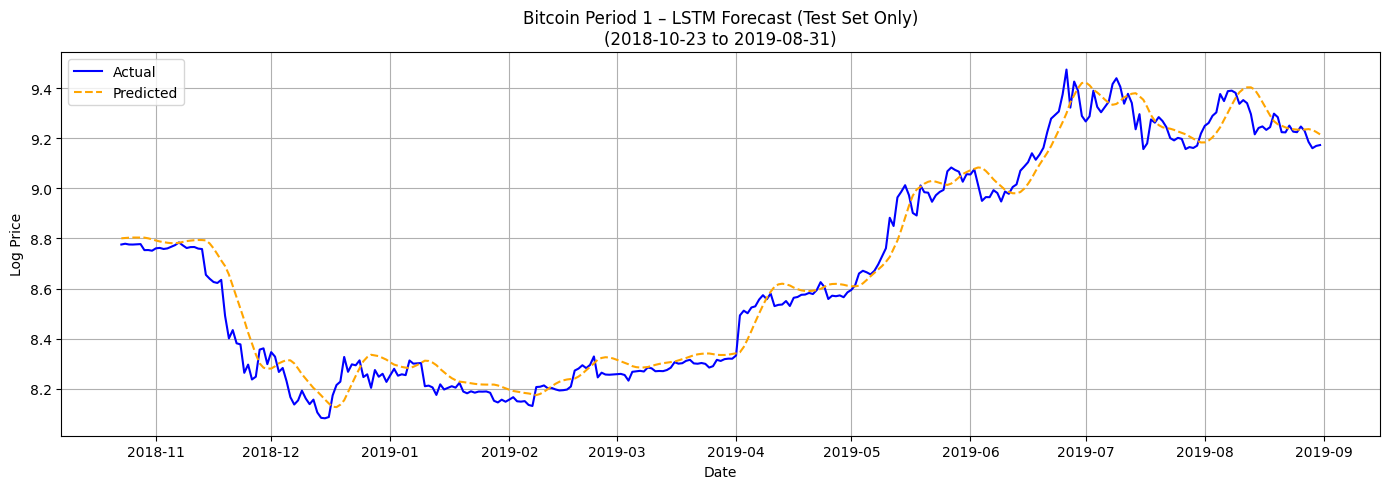


🚀 Running LSTM Forecast for Bitcoin – Period 2 (2019-09-01 to 2024-12-30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
📊 Bitcoin Period 2: RMSE = 0.05, MAE = 0.04


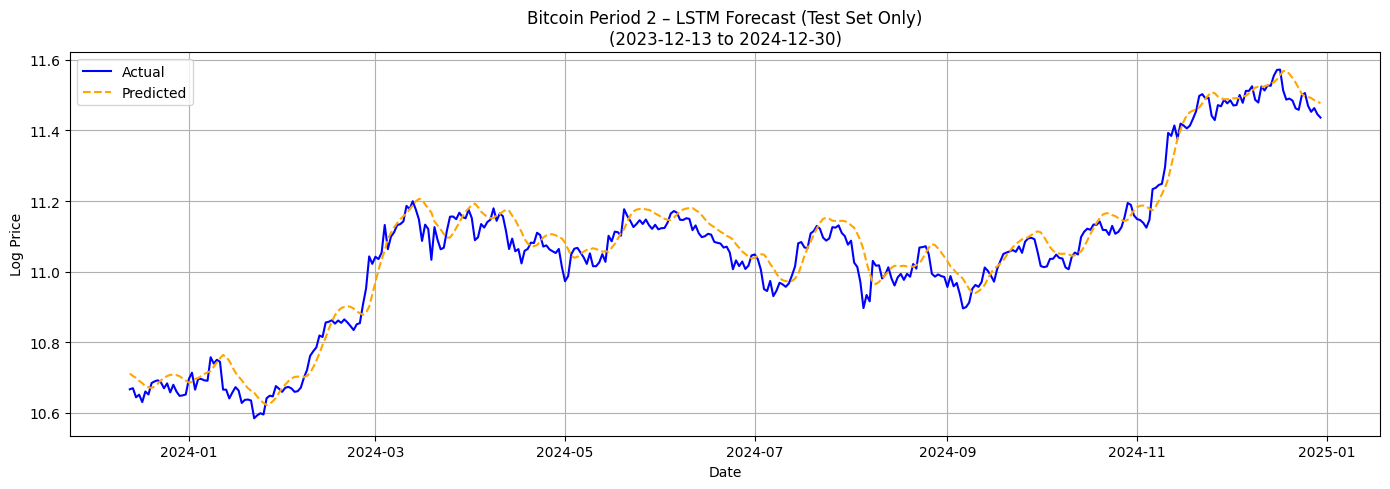


🚀 Running LSTM Forecast for Bitcoin – Period 3 (2014-10-01 to 2024-12-30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
📊 Bitcoin Period 3: RMSE = 0.05, MAE = 0.04


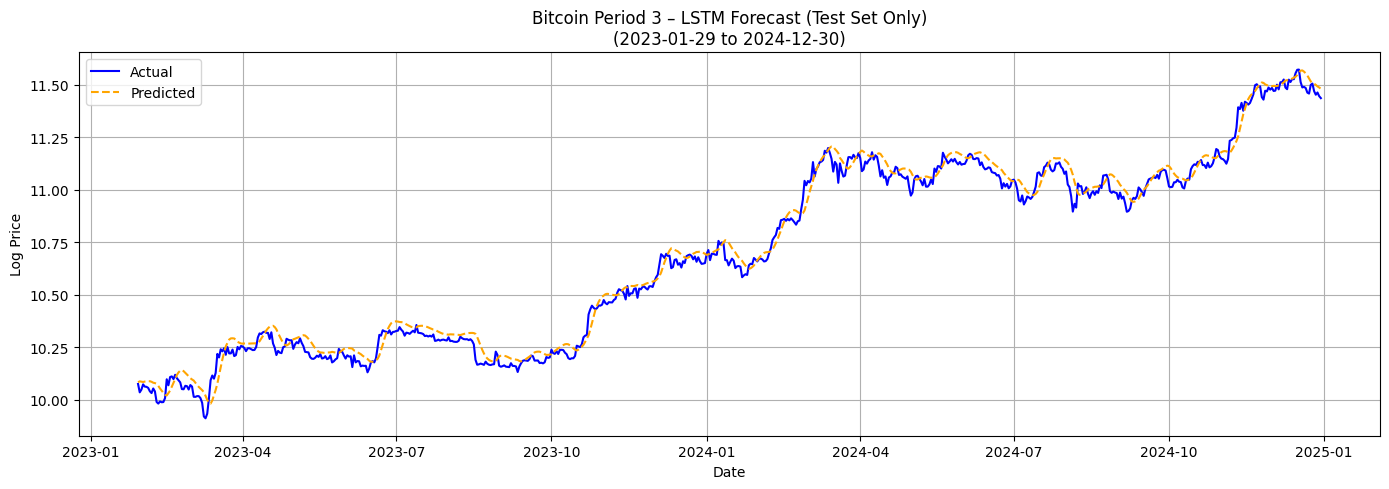


🔍 Starting forecasts for: Tesla

🚀 Running LSTM Forecast for Tesla – Period 1 (2014-10-01 to 2019-08-31)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📊 Tesla Period 1: RMSE = 0.05, MAE = 0.04


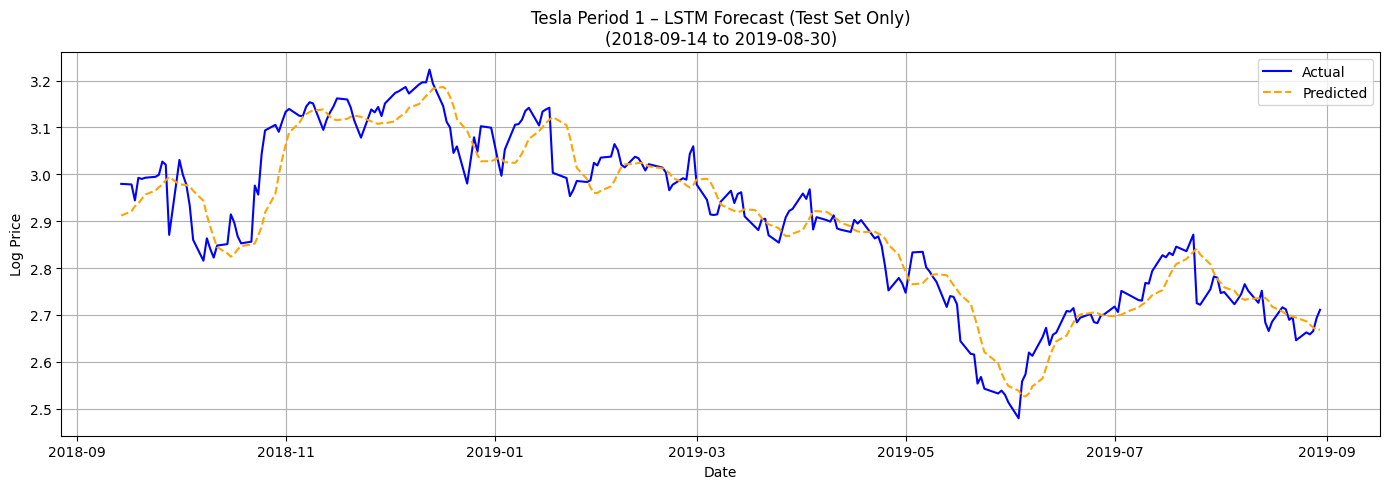


🚀 Running LSTM Forecast for Tesla – Period 2 (2019-09-01 to 2024-12-30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📊 Tesla Period 2: RMSE = 0.12, MAE = 0.10


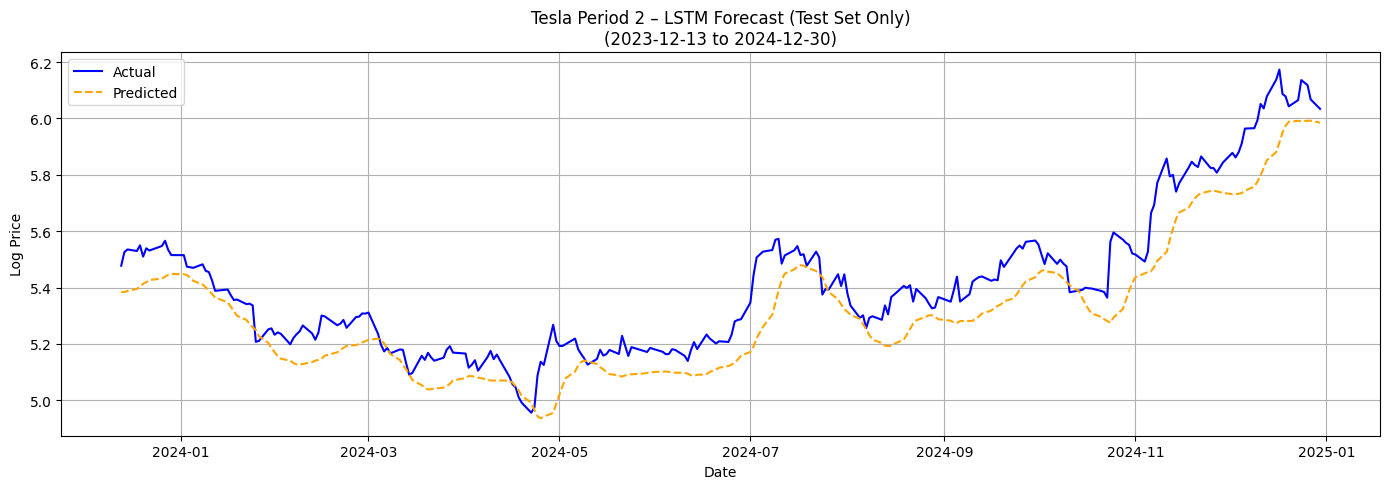


🚀 Running LSTM Forecast for Tesla – Period 3 (2014-10-01 to 2024-12-30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
📊 Tesla Period 3: RMSE = 0.06, MAE = 0.05


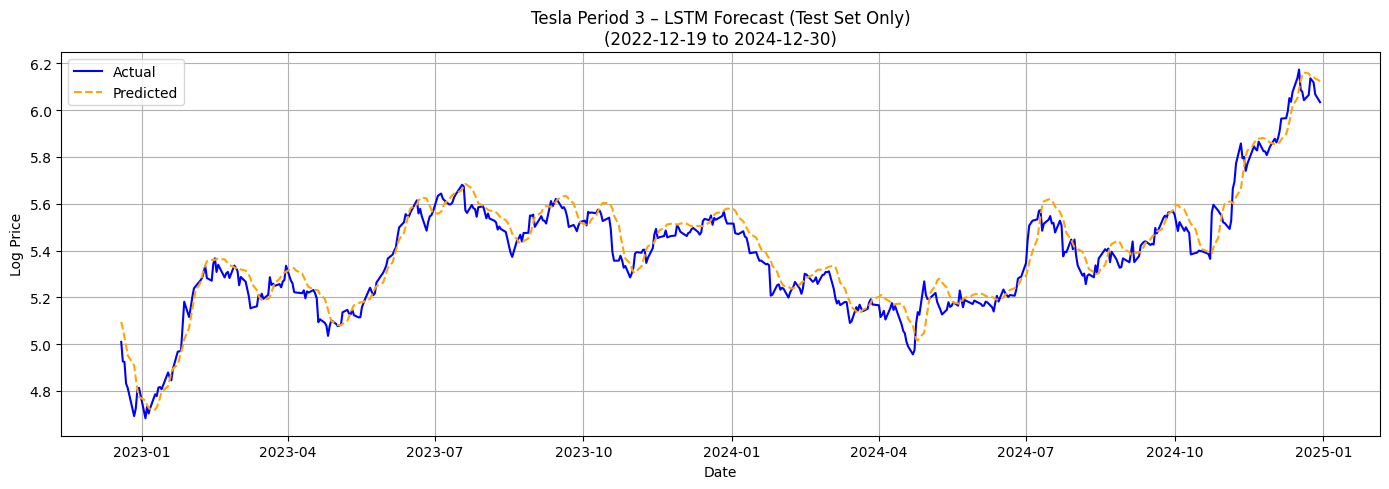


📊 Combined LSTM Forecast Summary:


Asset    Period      RMSE       MAE
0  Bitcoin  Period 1  0.070828  0.055194
1  Bitcoin  Period 2  0.045339  0.036223
2  Bitcoin  Period 3  0.047283  0.038425
3    Tesla  Period 1  0.052629  0.041241
4    Tesla  Period 2  0.119417  0.100388
5    Tesla  Period 3  0.064172  0.050371

📁 Forecast summary saved as 'btc_tsla_lstm_forecast_summary.csv'


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ✅ Periods (aligned globally)
periods = {
    "Period 1": ('2014-10-01', '2019-08-31'),
    "Period 2": ('2019-09-01', '2024-12-30'),
    "Period 3": ('2014-10-01', '2024-12-30')
}

# ✅ Assets to include
assets = ["Bitcoin", "Tesla"]

# ✅ Container for results
all_results = []

# ✅ Loop over assets and periods
for asset in assets:
    print(f"\n🔍 Starting forecasts for: {asset}\n{'='*50}")

    for period, (start_date, end_date) in periods.items():
        print(f"\n🚀 Running LSTM Forecast for {asset} – {period} ({start_date} to {end_date})")

        # 🔹 Load preprocessed data
        try:
            X = lstm_data[asset][period]['X']
            y = lstm_data[asset][period]['y']
            scaler = lstm_data[asset][period]['scaler']
            dates = lstm_data[asset][period]['dates']
        except KeyError:
            print(f"⚠️ Skipping {asset} - {period}: Data not found in lstm_data.")
            continue

        # 🔹 Train/Test split
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        test_dates = dates[split_idx:]

        # 🔹 Build the LSTM model
        model = Sequential([
            LSTM(64, return_sequences=False, input_shape=(X.shape[1], 1)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # 🔹 Train the model
        model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        # 🔹 Predict and inverse scale
        y_pred = model.predict(X_test)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # 🔹 Evaluation
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        print(f"📊 {asset} {period}: RMSE = {rmse:.2f}, MAE = {mae:.2f}")
        all_results.append((asset, period, rmse, mae))

        # 🔹 Plot forecast
        plt.figure(figsize=(14, 5))
        plt.plot(test_dates, y_test_inv, label='Actual', color='blue')
        plt.plot(test_dates, y_pred_inv, label='Predicted', color='orange', linestyle='--')
        plt.title(f"{asset} {period} – LSTM Forecast (Test Set Only)\n({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Log Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset.lower()}_forecast_{period.replace(' ', '_')}.png", dpi=300)
        plt.show()

# ✅ Convert results to DataFrame
summary_df = pd.DataFrame(all_results, columns=["Asset", "Period", "RMSE", "MAE"])
print("\n📊 Combined LSTM Forecast Summary:")
display(summary_df)

# ✅ Export results
summary_df.to_csv("btc_tsla_lstm_forecast_summary.csv", index=False)
print("📁 Forecast summary saved as 'btc_tsla_lstm_forecast_summary.csv'")


In [14]:
# If using a unified DataFrame like summary_df with ["Asset", "Period", "RMSE", "MAE"]
summary_file = "btc_tsla_lstm_forecast_summary.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✅ Combined LSTM results saved to: {summary_file}")
files.download(summary_file)


✅ Combined LSTM results saved to: btc_tsla_lstm_forecast_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import os
print(os.listdir())


['.config', 'bitcoin_features.csv', 'Tesla_stock.csv', 'bitcoin_forecast_Period_3.png', 'tesla_forecast_Period_3.png', 'tesla_forecast_Period_2.png', 'bitcoin_forecast_Period_1.png', 'tesla_features.csv', 'Bitcoin_data (1).csv', 'bitcoin_forecast_Period_2.png', 'Bitcoin_data.csv', 'Tesla_stock (1).csv', 'tesla_forecast_Period_1.png', 'btc_tsla_lstm_forecast_summary.csv', 'sample_data']


In [16]:
# ✅ INSTALL TA-LIB-like package (ta)
!pip install ta

# ✅ IMPORT LIBRARIES
import pandas as pd
import numpy as np
from ta.trend import EMAIndicator, SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# ✅ COMMON PARAMETERS
start_date = "2014-10-01"
end_date = "2024-12-30"
sma_spans = [12, 20, 26, 48, 220]
ema_spans = [12, 26, 48, 220]

def generate_features(df, asset_name):
    df = df.copy()
    df = df.loc[start_date:end_date]
    df["returns"] = df["Close"].pct_change()

    # SMA
    for span in sma_spans:
        df[f"SMA{span}"] = SMAIndicator(close=df["Close"], window=span).sma_indicator()

    # EMA
    for span in ema_spans:
        df[f"EMA{span}"] = EMAIndicator(close=df["Close"], window=span).ema_indicator()

    # RSI & MACD
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["MACD"] = MACD(close=df["Close"]).macd()

    # Bollinger Bands
    bb = BollingerBands(close=df["Close"])
    df["Upper_BB"] = bb.bollinger_hband()
    df["Lower_BB"] = bb.bollinger_lband()

    # Drop NA
    df.dropna(inplace=True)

    # Export
    filename = f"{asset_name.lower()}_features.csv"
    df.to_csv(filename)
    print(f"✅ {filename} saved with indicators from {df.index.min().date()} to {df.index.max().date()}")
    return df

# ✅ Load and process Bitcoin
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True)
btc.set_index("Date", inplace=True)
btc.sort_index(inplace=True)
btc = generate_features(btc, "Bitcoin")

# ✅ Load and process Tesla (✅ Updated file path)
tsla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
tsla.set_index("Date", inplace=True)
tsla.sort_index(inplace=True)
tsla = generate_features(tsla, "Tesla")


✅ bitcoin_features.csv saved with indicators from 2015-05-08 to 2024-12-30
✅ tesla_features.csv saved with indicators from 2015-08-14 to 2024-12-30


In [17]:
# ✅ INSTALL TA-LIB-like package (ta)
!pip install ta

# ✅ IMPORT LIBRARIES
import pandas as pd
import numpy as np
from ta.trend import EMAIndicator, SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# ✅ COMMON SETTINGS
start_date = "2014-10-01"
end_date = "2024-12-30"
sma_spans = [12, 20, 26, 48, 220]
ema_spans = [12, 26, 48, 220]

# ✅ FEATURE ENGINEERING FUNCTION
def generate_features(df, asset_name):
    df = df.copy()
    df = df.loc[start_date:end_date]
    df["returns"] = df["Close"].pct_change()

    for span in sma_spans:
        df[f"SMA{span}"] = SMAIndicator(close=df["Close"], window=span).sma_indicator()

    for span in ema_spans:
        df[f"EMA{span}"] = EMAIndicator(close=df["Close"], window=span).ema_indicator()

    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["MACD"] = MACD(close=df["Close"]).macd()

    bb = BollingerBands(close=df["Close"])
    df["Upper_BB"] = bb.bollinger_hband()
    df["Lower_BB"] = bb.bollinger_lband()

    df.dropna(inplace=True)

    output_file = f"{asset_name.lower()}_features.csv"
    df.to_csv(output_file)
    print(f"✅ {output_file} saved with indicators from {df.index.min().date()} to {df.index.max().date()}")
    return df

# ✅ Load and process Bitcoin
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True)
btc.set_index("Date", inplace=True)
btc.sort_index(inplace=True)
btc = generate_features(btc, "Bitcoin")

# ✅ Load and process Tesla (use correct file path)
tsla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
tsla.set_index("Date", inplace=True)
tsla.sort_index(inplace=True)
tsla = generate_features(tsla, "Tesla")


✅ bitcoin_features.csv saved with indicators from 2015-05-08 to 2024-12-30
✅ tesla_features.csv saved with indicators from 2015-08-14 to 2024-12-30


In [18]:
# 📚 Required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# 🛠️ Helper Functions
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    return rmse, mse, mae, mape, r2

def build_model(model_type, input_shape):
    model = Sequential()
    if model_type == "Vanilla":
        model.add(LSTM(50, activation='relu', input_shape=input_shape))
    elif model_type == "Stacked 1":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50, activation='relu'))
    elif model_type == "Stacked 2":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50, activation='relu', return_sequences=True))
        model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# ✅ Feature Sets
feature_sets = {
    "Close": ["Close"],
    "Close, Returns": ["Close", "returns"],
    "Close, EMA12, EMA26, EMA48, EMA220": ["Close", "EMA12", "EMA26", "EMA48", "EMA220"],
    "Close, SMA12, SMA26, SMA20, SMA48, SMA220": ["Close", "SMA12", "SMA26", "SMA20", "SMA48", "SMA220"],
    "Close, RSI, MACD": ["Close", "RSI", "MACD"],
    "Close, Upper Bollinger Band, Lower Bollinger Band": ["Close", "Upper_BB", "Lower_BB"],
    "Close, EMA + SMA + Bollinger": [
        "Close", "EMA12", "EMA26", "EMA48", "EMA220",
        "SMA12", "SMA26", "SMA20", "SMA48", "SMA220",
        "Upper_BB", "Lower_BB"
    ],
    "Close, EMA + SMA + Bollinger + RSI + MACD": [
        "Close", "EMA12", "EMA26", "EMA48", "EMA220",
        "SMA12", "SMA26", "SMA20", "SMA48", "SMA220",
        "Upper_BB", "Lower_BB", "RSI", "MACD"
    ]
}

# ✅ Periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# ✅ Assets and files
assets = {
    "Bitcoin": "bitcoin_features.csv",
    "Tesla": "tesla_features.csv"
}

# 📈 LSTM Evaluation for Each Asset
seq_len = 10
model_types = ["Vanilla", "Stacked 1", "Stacked 2"]
all_results = []

for asset_name, file_path in assets.items():
    print(f"\n📂 Processing {asset_name}")
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    df["returns"] = df["Close"].pct_change().fillna(0)

    for feat_name, features in feature_sets.items():
        for period_name, (start, end) in periods.items():
            best_result = None
            best_rmse = float("inf")

            try:
                dfx = df.loc[start:end, features].dropna().copy()
                dfx["Target"] = dfx["Close"]
            except KeyError as e:
                print(f"⚠️ Skipping {asset_name} | {feat_name} | {period_name} — Missing: {e}")
                continue

            for model_type in model_types:
                print(f"🔁 {asset_name} | {feat_name} | {period_name} | {model_type}")

                scaler = MinMaxScaler()
                scaled = scaler.fit_transform(dfx)
                scaled_df = pd.DataFrame(scaled, columns=features + ["Target"], index=dfx.index)

                train_size = int(len(scaled_df) * 0.8)
                train = scaled_df.iloc[:train_size].values
                test = scaled_df.iloc[train_size:].values

                X_train, y_train = create_sequences(train, seq_len)
                X_test, y_test = create_sequences(test, seq_len)

                if len(X_train) == 0 or len(X_test) == 0:
                    continue

                model = build_model(model_type, (X_train.shape[1], X_train.shape[2]))
                model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                y_pred = model.predict(X_test, verbose=0)

                y_pred_inv = scaler.inverse_transform(
                    np.concatenate((np.zeros((len(y_pred), len(features))), y_pred), axis=1)
                )[:, -1]
                y_true_inv = scaler.inverse_transform(
                    np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1)
                )[:, -1]

                rmse, mse, mae, mape, r2 = evaluate_model(y_true_inv, y_pred_inv)

                if rmse < best_rmse:
                    best_result = [asset_name, feat_name, period_name, model_type,
                                   round(rmse, 2), round(mse, 2), round(mae, 2),
                                   f"{mape:.2f}%", round(r2, 4)]
                    best_rmse = rmse

            if best_result:
                all_results.append(best_result)

# 📋 Save Final Results
summary_df = pd.DataFrame(all_results, columns=[
    "Asset", "Features", "Period", "Best Model", "RMSE", "MSE", "MAE", "MAPE", "R2"
])
summary_file = "btc_tsla_lstm_forecast_summary.csv"
summary_df.to_csv(summary_file, index=False)
files.download(summary_file)
print(f"✅ LSTM multivariate results saved and downloaded as: {summary_file}")



📂 Processing Bitcoin
🔁 Bitcoin | Close | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



📂 Processing Tesla
🔁 Tesla | Close | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ LSTM multivariate results saved and downloaded as: btc_tsla_lstm_forecast_summary.csv


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ Parameters
seq_len = 10
start_date = "2014-10-01"
end_date = "2024-12-30"

# ✅ Load datasets
btc = pd.read_csv("bitcoin_features.csv", parse_dates=["Date"])
tsla = pd.read_csv("tesla_features.csv", parse_dates=["Date"])

btc.set_index("Date", inplace=True)
tsla.set_index("Date", inplace=True)

# ✅ Common helper: sequence generator
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

# ✅ Features
features = ["Close", "Upper_BB", "Lower_BB"]

# ✅ Dictionary to store everything
assets = {
    "Bitcoin": btc,
    "Tesla": tsla
}
histories = {}
models = {}

for asset, df in assets.items():
    print(f"📈 Preparing data for {asset}")

    df = df.loc[start_date:end_date, features].dropna().copy()
    df["Target"] = df["Close"]

    # Normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled, columns=features + ["Target"], index=df.index)

    # Create sequences
    X, y = create_sequences(df_scaled.values, seq_len)
    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # ✅ Build and train model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(f"🚀 Training LSTM for {asset}")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )

    histories[asset] = history
    models[asset] = model
    print(f"✅ Model trained for {asset}")

# ✅ Access history: histories["Bitcoin"].history['loss'], etc.


📈 Preparing data for Bitcoin
🚀 Training LSTM for Bitcoin


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Model trained for Bitcoin
📈 Preparing data for Tesla
🚀 Training LSTM for Tesla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Model trained for Tesla


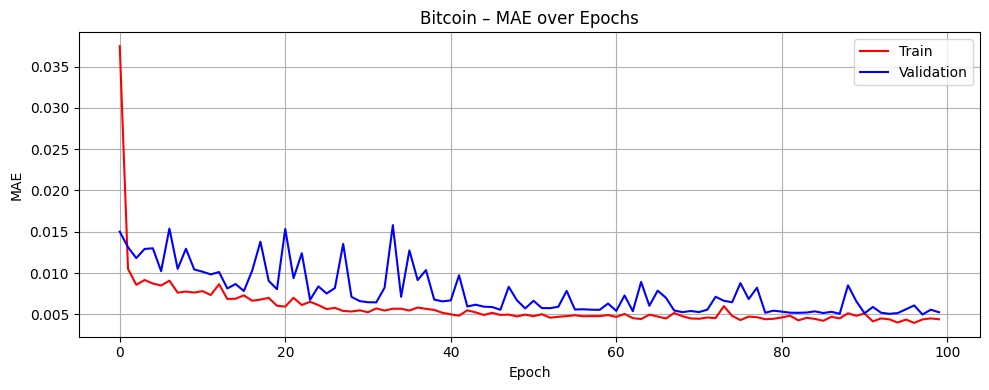

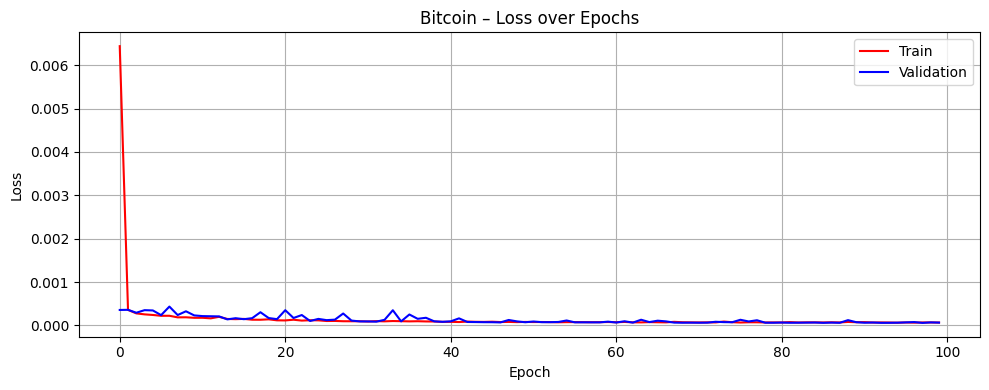

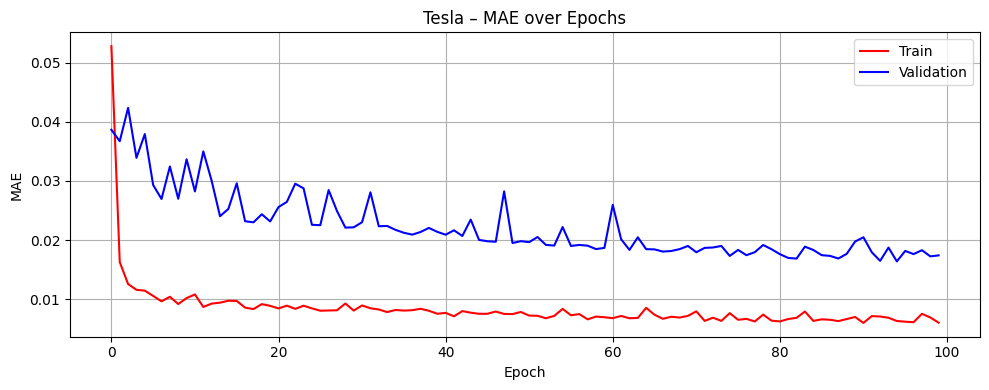

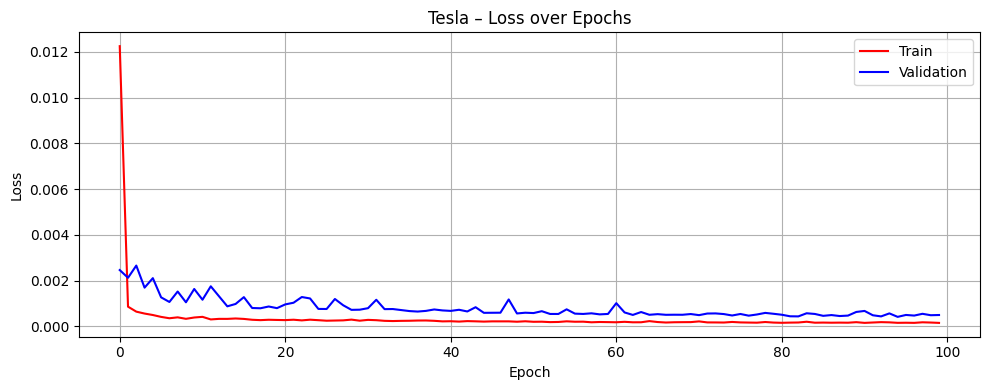

In [20]:
import matplotlib.pyplot as plt

# ✅ Asset-wise plotting
for asset_name, history in histories.items():
    # --- MAE Plot ---
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['mae'], label='Train', color='red')
    plt.plot(history.history['val_mae'], label='Validation', color='blue')
    plt.title(f"{asset_name} – MAE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"mae_epoch_plot_{asset_name}.png", dpi=300)
    plt.show()

    # --- Loss Plot ---
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train', color='red')
    plt.plot(history.history['val_loss'], label='Validation', color='blue')
    plt.title(f"{asset_name} – Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"loss_epoch_plot_{asset_name}.png", dpi=300)
    plt.show()


In [21]:
# ✅ INSTALL TA-LIB-like package (ta)
!pip install ta

# ✅ IMPORT LIBRARIES
import pandas as pd
import numpy as np
from ta.trend import EMAIndicator, SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# ✅ CONFIGURATION
start_date = "2014-10-01"
end_date = "2024-12-30"
sma_spans = [12, 20, 26, 48, 220]
ema_spans = [12, 26, 48, 220]

# ✅ Feature Engineering Function
def generate_features(df, asset_name):
    df = df.copy()
    df = df.loc[start_date:end_date]
    df["returns"] = df["Close"].pct_change()

    # Add SMA
    for span in sma_spans:
        df[f"SMA{span}"] = SMAIndicator(close=df["Close"], window=span).sma_indicator()

    # Add EMA
    for span in ema_spans:
        df[f"EMA{span}"] = EMAIndicator(close=df["Close"], window=span).ema_indicator()

    # RSI and MACD
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["MACD"] = MACD(close=df["Close"]).macd()

    # Bollinger Bands
    bb = BollingerBands(close=df["Close"])
    df["Upper_BB"] = bb.bollinger_hband()
    df["Lower_BB"] = bb.bollinger_lband()

    # Drop NA values
    df.dropna(inplace=True)

    # Export
    output_file = f"{asset_name.lower()}_features.csv"
    df.to_csv(output_file)
    print(f"✅ {output_file} saved with indicators from {df.index.min().date()} to {df.index.max().date()}")
    return df

# ✅ Process Bitcoin
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True)
btc.set_index("Date", inplace=True)
btc.sort_index(inplace=True)
btc_features = generate_features(btc, "Bitcoin")

# ✅ Process Tesla
tsla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
tsla.set_index("Date", inplace=True)
tsla.sort_index(inplace=True)
tsla_features = generate_features(tsla, "Tesla")


✅ bitcoin_features.csv saved with indicators from 2015-05-08 to 2024-12-30
✅ tesla_features.csv saved with indicators from 2015-08-14 to 2024-12-30


In [22]:
# ✅ INSTALL TA-LIB-like package (ta)
!pip install ta

# ✅ IMPORT LIBRARIES
import pandas as pd
import numpy as np
from ta.trend import EMAIndicator, SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# ✅ CONFIGURATION
start_date = "2014-10-01"
end_date = "2024-12-30"
sma_spans = [12, 20, 26, 48, 220]
ema_spans = [12, 26, 48, 220]

# ✅ Feature Engineering Function
def generate_features(df, asset_name):
    df = df.copy()
    df = df.loc[start_date:end_date]
    df["returns"] = df["Close"].pct_change()

    # Add SMA
    for span in sma_spans:
        df[f"SMA{span}"] = SMAIndicator(close=df["Close"], window=span).sma_indicator()

    # Add EMA
    for span in ema_spans:
        df[f"EMA{span}"] = EMAIndicator(close=df["Close"], window=span).ema_indicator()

    # RSI and MACD
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["MACD"] = MACD(close=df["Close"]).macd()

    # Bollinger Bands
    bb = BollingerBands(close=df["Close"])
    df["Upper_BB"] = bb.bollinger_hband()
    df["Lower_BB"] = bb.bollinger_lband()

    # Drop NA values
    df.dropna(inplace=True)

    # Export
    output_file = f"{asset_name.lower()}_features.csv"
    df.to_csv(output_file)
    print(f"✅ {output_file} saved with indicators from {df.index.min().date()} to {df.index.max().date()}")
    return df

# ✅ Load and process Bitcoin
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True)
btc.set_index("Date", inplace=True)
btc.sort_index(inplace=True)
btc_features = generate_features(btc, "Bitcoin")

# ✅ Load and process Tesla
tsla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
tsla.set_index("Date", inplace=True)
tsla.sort_index(inplace=True)
tsla_features = generate_features(tsla, "Tesla")


✅ bitcoin_features.csv saved with indicators from 2015-05-08 to 2024-12-30
✅ tesla_features.csv saved with indicators from 2015-08-14 to 2024-12-30


In [23]:
# 📚 Required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# 🛠️ Helper Functions
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    return rmse, mse, mae, mape, r2

def build_model(model_type, input_shape):
    model = Sequential()
    if model_type == "Vanilla":
        model.add(LSTM(50, activation='relu', input_shape=input_shape))
    elif model_type == "Stacked 1":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50, activation='relu'))
    elif model_type == "Stacked 2":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50, activation='relu', return_sequences=True))
        model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# ✅ Feature Sets
feature_sets = {
    "Close": ["Close"],
    "Close, Returns": ["Close", "returns"],
    "Close, EMA12, EMA26, EMA48, EMA220": ["Close", "EMA12", "EMA26", "EMA48", "EMA220"],
    "Close, SMA12, SMA26, SMA20, SMA48, SMA220": ["Close", "SMA12", "SMA26", "SMA20", "SMA48", "SMA220"],
    "Close, RSI, MACD": ["Close", "RSI", "MACD"],
    "Close, Upper Bollinger Band, Lower Bollinger Band": ["Close", "Upper_BB", "Lower_BB"],
    "Close, EMA + SMA + Bollinger": [
        "Close", "EMA12", "EMA26", "EMA48", "EMA220",
        "SMA12", "SMA26", "SMA20", "SMA48", "SMA220",
        "Upper_BB", "Lower_BB"
    ],
    "Close, EMA + SMA + Bollinger + RSI + MACD": [
        "Close", "EMA12", "EMA26", "EMA48", "EMA220",
        "SMA12", "SMA26", "SMA20", "SMA48", "SMA220",
        "Upper_BB", "Lower_BB", "RSI", "MACD"
    ]
}

# ✅ Periods
periods = {
    "Period 1": ('2014-10-01', '2019-08-31'),
    "Period 2": ('2019-09-01', '2024-12-30'),
    "Period 3": ('2014-10-01', '2024-12-30')
}

# ✅ Assets
assets = {
    "Bitcoin": "bitcoin_features.csv",
    "Tesla": "tesla_features.csv"
}

# 🔁 Train and Evaluate
seq_len = 10
model_types = ["Vanilla", "Stacked 1", "Stacked 2"]
all_results = []

for asset_name, file_path in assets.items():
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    df["returns"] = df["Close"].pct_change().fillna(0)

    for feat_name, features in feature_sets.items():
        for period_name, (start, end) in periods.items():
            best_result = None
            best_rmse = float("inf")

            # Safely skip if missing columns
            missing_cols = [f for f in features if f not in df.columns]
            if missing_cols:
                print(f"⚠️ Skipping {asset_name} | {feat_name} | {period_name} — missing: {missing_cols}")
                continue

            try:
                sub_df = df.loc[start:end, features].dropna().copy()
                sub_df["Target"] = sub_df["Close"]
            except Exception as e:
                print(f"❌ Error in {asset_name} | {feat_name} | {period_name}: {e}")
                continue

            for model_type in model_types:
                print(f"🔁 {asset_name} | {feat_name} | {period_name} | {model_type}")
                scaler = MinMaxScaler()
                scaled = scaler.fit_transform(sub_df)
                scaled_df = pd.DataFrame(scaled, columns=features + ["Target"], index=sub_df.index)

                train_size = int(len(scaled_df) * 0.8)
                train = scaled_df.iloc[:train_size].values
                test = scaled_df.iloc[train_size:].values

                X_train, y_train = create_sequences(train, seq_len)
                X_test, y_test = create_sequences(test, seq_len)

                if len(X_train) == 0 or len(X_test) == 0:
                    continue

                model = build_model(model_type, (X_train.shape[1], X_train.shape[2]))
                model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                y_pred = model.predict(X_test, verbose=0)
                y_pred_rescaled = scaler.inverse_transform(
                    np.concatenate((np.zeros((len(y_pred), len(features))), y_pred), axis=1)
                )[:, -1]
                y_true_rescaled = scaler.inverse_transform(
                    np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1)
                )[:, -1]

                rmse, mse, mae, mape, r2 = evaluate_model(y_true_rescaled, y_pred_rescaled)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_result = [
                        asset_name, feat_name, period_name, model_type,
                        round(rmse, 2), round(mse, 2), round(mae, 2),
                        f"{mape:.2f}%", round(r2, 4)
                    ]

            if best_result:
                all_results.append(best_result)

# 📋 Save Summary Table
columns = ["Asset", "Features", "Period", "Best Model", "RMSE", "MSE", "MAE", "MAPE", "R2"]
summary_df = pd.DataFrame(all_results, columns=columns)
summary_df.to_csv("btc_tsla_lstm_forecast_summary.csv", index=False)
files.download("btc_tsla_lstm_forecast_summary.csv")
print("✅ LSTM multivariate results saved and downloaded as: btc_tsla_lstm_forecast_summary.csv")


🔁 Bitcoin | Close | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Returns | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, RSI, MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Bitcoin | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Returns | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA12, EMA26, EMA48, EMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, SMA12, SMA26, SMA20, SMA48, SMA220 | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, RSI, MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, Upper Bollinger Band, Lower Bollinger Band | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 1 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 2 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Vanilla


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔁 Tesla | Close, EMA + SMA + Bollinger + RSI + MACD | Period 3 | Stacked 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ LSTM multivariate results saved and downloaded as: btc_tsla_lstm_forecast_summary.csv


<ipython-input-24-36b6777c6d39>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Period", y="RMSE", hue="Features", ci=None)


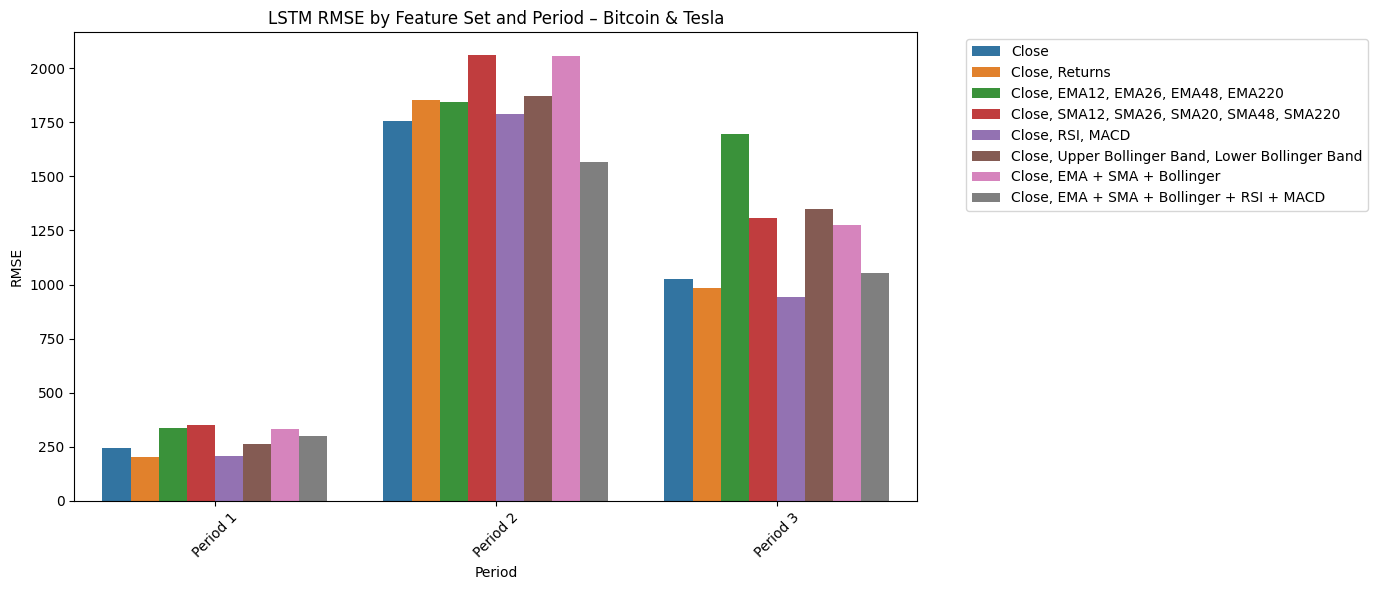

<ipython-input-24-36b6777c6d39>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Period", y="MAE", hue="Features", ci=None)


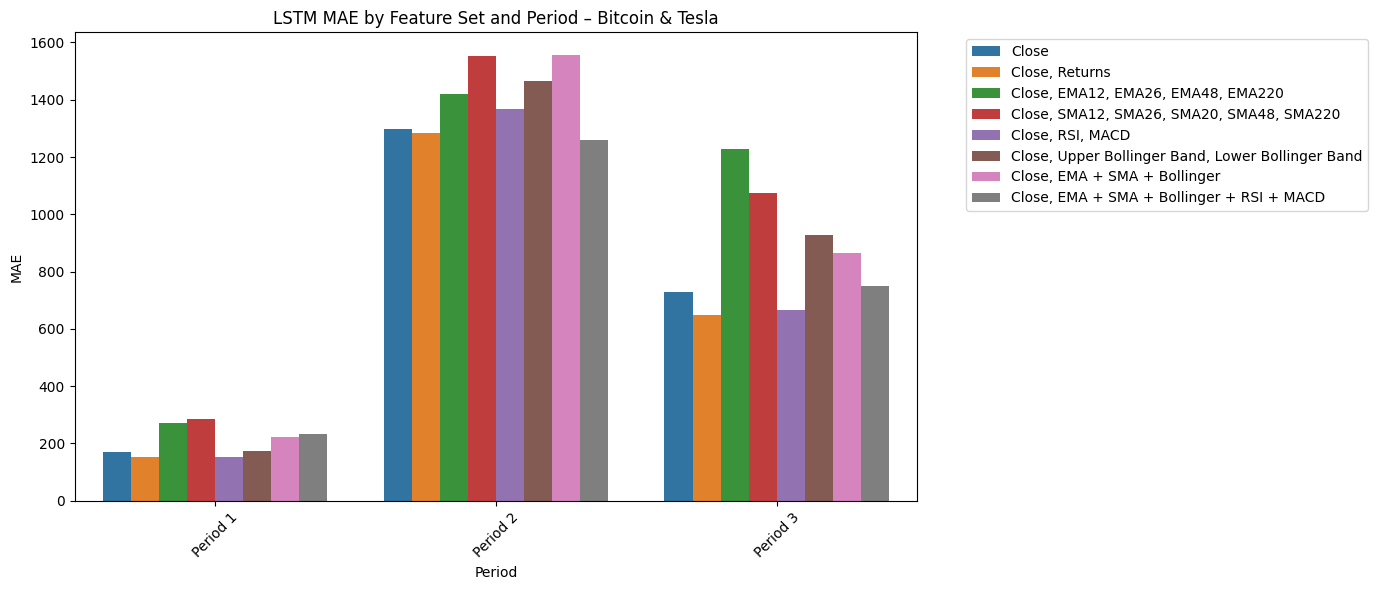

In [24]:
# ✅ IMPORT LIBRARIES
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load the combined results file
df = pd.read_csv("btc_tsla_lstm_forecast_summary.csv")

# ✅ RMSE Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="Period", y="RMSE", hue="Features", ci=None)
plt.title("LSTM RMSE by Feature Set and Period – Bitcoin & Tesla")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ MAE Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="Period", y="MAE", hue="Features", ci=None)
plt.title("LSTM MAE by Feature Set and Period – Bitcoin & Tesla")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [25]:
!pip install ta --quiet


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [27]:
# 📚 Required Libraries
import pandas as pd

# ✅ Define global periods
periods = {
    "Period 1": ('2014-10-01', '2019-08-31'),
    "Period 2": ('2019-09-01', '2024-12-30'),
    "Period 3": ('2014-10-01', '2024-12-30')
}

# ✅ Select best-performing features (from multivariate LSTM result)
features = ["Close", "Upper_BB", "Lower_BB"]

# ✅ Choose period to filter
selected_period = "Period 1"
start, end = periods[selected_period]

# ✅ Function to prepare asset
def load_asset(asset_name, file_path):
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    df = df[features].dropna().copy()
    df["Target"] = df["Close"]
    df = df.loc[start:end]
    print(f"✅ {asset_name} | {selected_period} — Data from {df.index.min().date()} to {df.index.max().date()}")
    print(f"✅ Features: {features}")
    return df

# ✅ Load Bitcoin and Tesla
btc_df = load_asset("Bitcoin", "bitcoin_features.csv")
tsla_df = load_asset("Tesla", "tesla_features.csv")

# Optional: Preview one of them
print("\n🔹 Bitcoin Head:")
print(btc_df.head())

print("\n🔹 Tesla Head:")
print(tsla_df.head())


✅ Bitcoin | Period 1 — Data from 2015-05-08 to 2019-08-31
✅ Features: ['Close', 'Upper_BB', 'Lower_BB']
✅ Tesla | Period 1 — Data from 2015-08-14 to 2019-08-30
✅ Features: ['Close', 'Upper_BB', 'Lower_BB']

🔹 Bitcoin Head:
                 Close    Upper_BB    Lower_BB      Target
Date                                                      
2015-05-08  243.863007  244.589746  219.490254  243.863007
2015-05-09  241.832001  245.457578  220.545622  241.832001
2015-05-10  240.296005  246.004243  221.565957  240.296005
2015-05-11  242.158005  246.873709  221.385391  242.158005
2015-05-12  241.111999  247.579136  221.373564  241.111999

🔹 Tesla Head:
                Close   Upper_BB   Lower_BB     Target
Date                                                  
2015-08-14  16.209999  18.887359  15.455841  16.209999
2015-08-17  16.999332  18.621812  15.539588  16.999332
2015-08-18  17.381332  18.574588  15.546479  17.381332
2015-08-19  17.016666  18.487642  15.549291  17.016666
2015-08-20  16.1453

In [28]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

# ✅ Parameters
seq_len = 10
start, end = "2014-10-01", "2019-08-31"
features = ["Close", "Upper_BB", "Lower_BB"]

# ✅ Helper function to create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# ✅ Load Bitcoin
btc = pd.read_csv("bitcoin_features.csv", parse_dates=["Date"])
btc.set_index("Date", inplace=True)
btc = btc.loc[start:end, features].dropna().copy()
btc["Target"] = btc["Close"]

# ✅ Scale and create sequences
btc_scaler = MinMaxScaler()
btc_scaled = btc_scaler.fit_transform(btc)
btc_X, btc_y = create_sequences(btc_scaled, seq_len)
btc_train_size = int(len(btc_X) * 0.8)
btc_X_train, btc_y_train = btc_X[:btc_train_size], btc_y[:btc_train_size]

# ✅ Load Tesla
tsla = pd.read_csv("tesla_features.csv", parse_dates=["Date"])
tsla.set_index("Date", inplace=True)
tsla = tsla.loc[start:end, features].dropna().copy()
tsla["Target"] = tsla["Close"]

tsla_scaler = MinMaxScaler()
tsla_scaled = tsla_scaler.fit_transform(tsla)
tsla_X, tsla_y = create_sequences(tsla_scaled, seq_len)
tsla_train_size = int(len(tsla_X) * 0.8)
tsla_X_train, tsla_y_train = tsla_X[:tsla_train_size], tsla_y[:tsla_train_size]

# ✅ Train models for both assets
training_histories = {}
for asset_name, (X_train, y_train) in {
    "Bitcoin": (btc_X_train, btc_y_train),
    "Tesla": (tsla_X_train, tsla_y_train)
}.items():
    print(f"\n🚀 Training LSTM model for {asset_name}")

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )

    training_histories[asset_name] = history
    print(f"✅ {asset_name} model training complete.")



🚀 Training LSTM model for Bitcoin


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Bitcoin model training complete.

🚀 Training LSTM model for Tesla
✅ Tesla model training complete.


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# ✅ Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# ✅ Train model with 10% validation split
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=0  # Set to 1 or 2 for detailed training logs
)

print("✅ Model training complete.")


✅ Model training complete.



📈 Plotting training history for Bitcoin


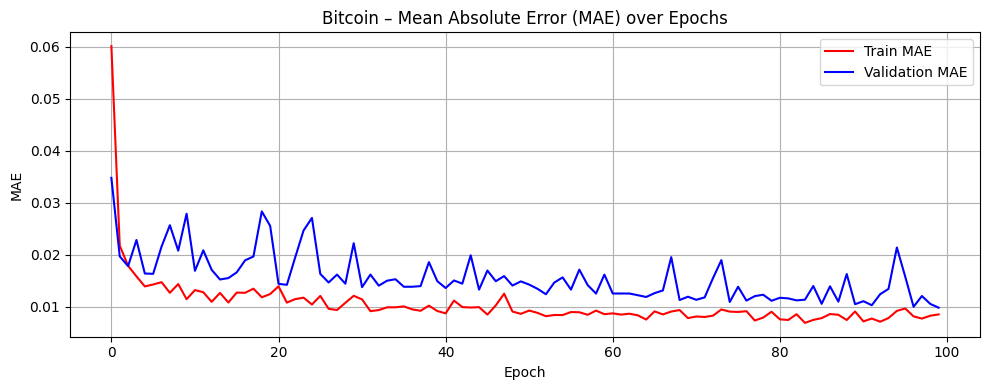

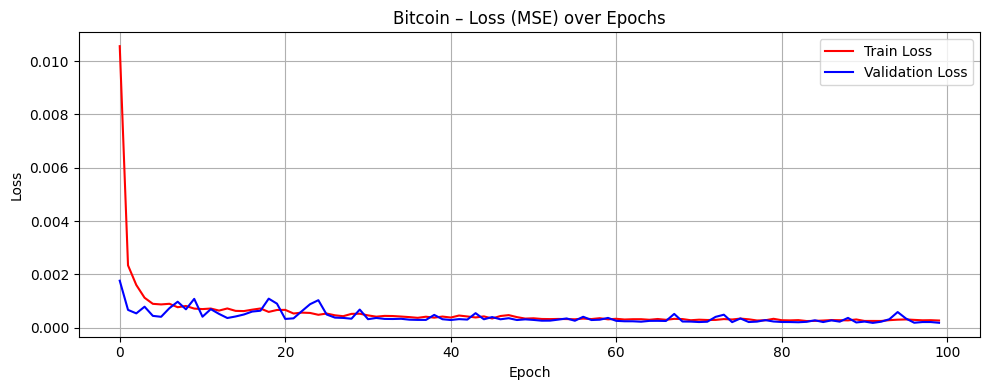


📈 Plotting training history for Tesla


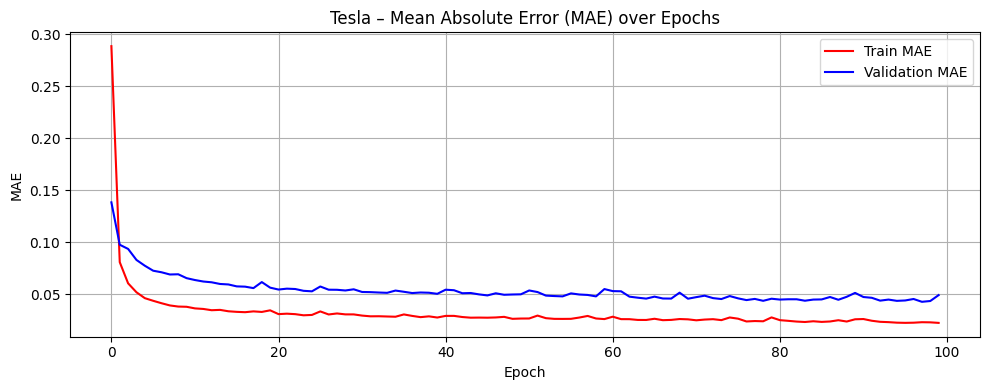

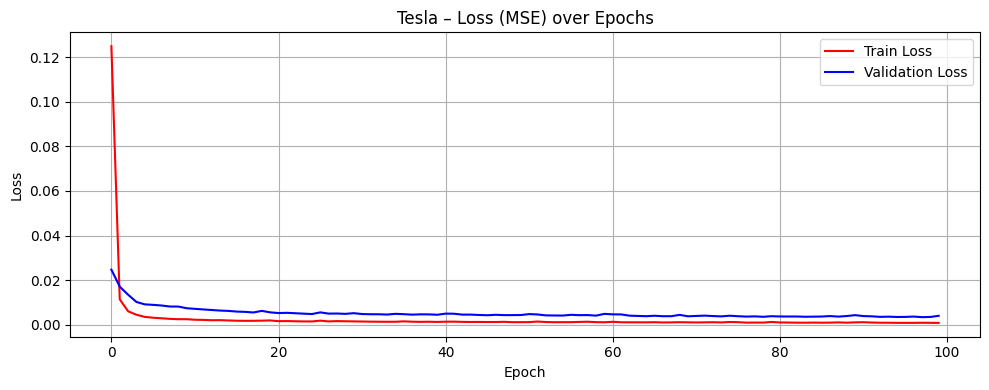

In [30]:
import matplotlib.pyplot as plt

# ✅ Plot MAE and Loss for Each Asset
for asset_name, history in training_histories.items():
    print(f"\n📈 Plotting training history for {asset_name}")

    # --- MAE Plot ---
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['mae'], label='Train MAE', color='red')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='blue')
    plt.title(f"{asset_name} – Mean Absolute Error (MAE) over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{asset_name.lower()}_mae_epoch_plot.png", dpi=300)
    plt.show()

    # --- Loss Plot ---
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
    plt.title(f"{asset_name} – Loss (MSE) over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{asset_name.lower()}_loss_epoch_plot.png", dpi=300)
    plt.show()



📊 Asset: Bitcoin
🔍 Period 1 with Vanilla LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


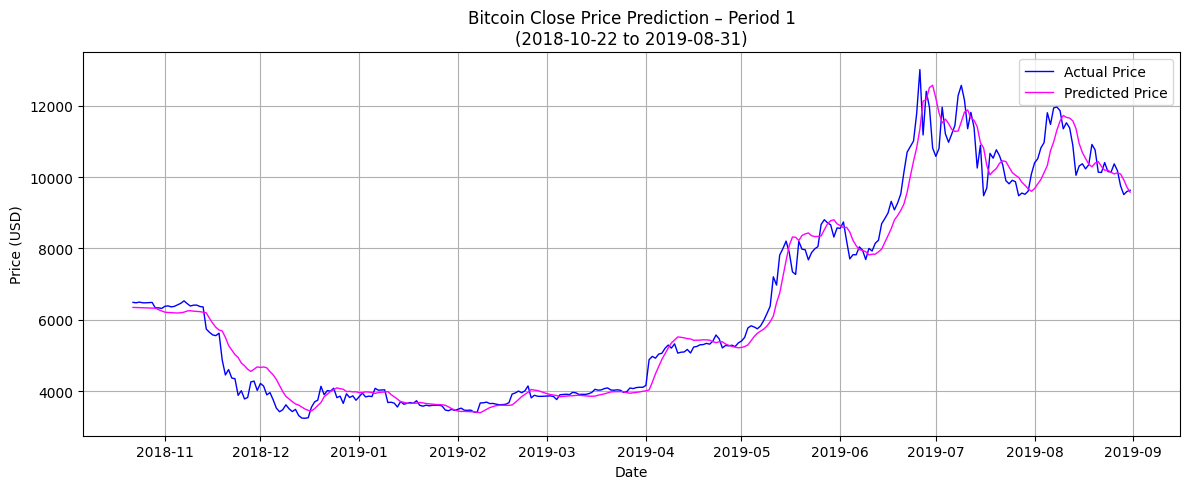

🔍 Period 2 with Vanilla LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


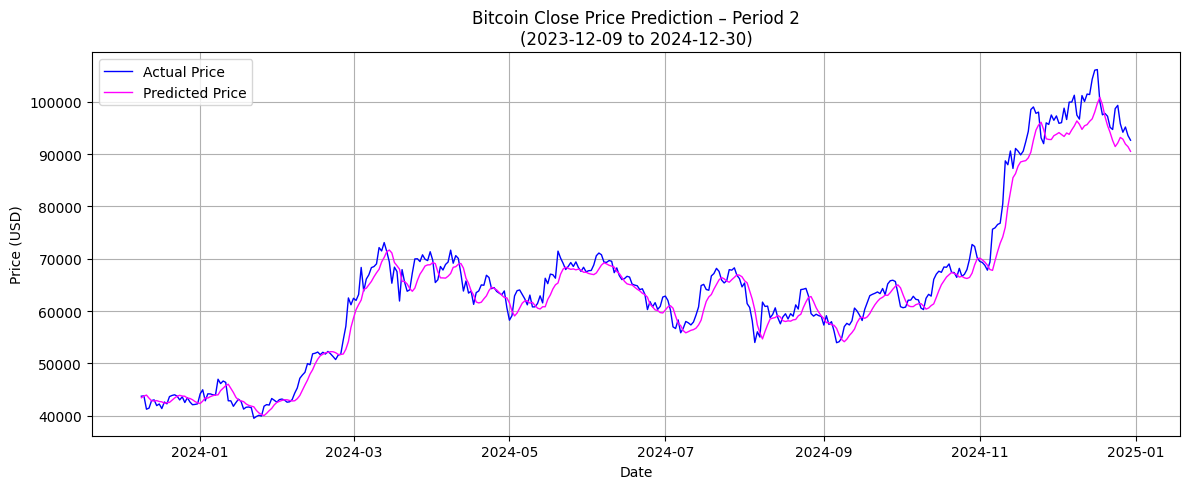

🔍 Period 3 with Stacked LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


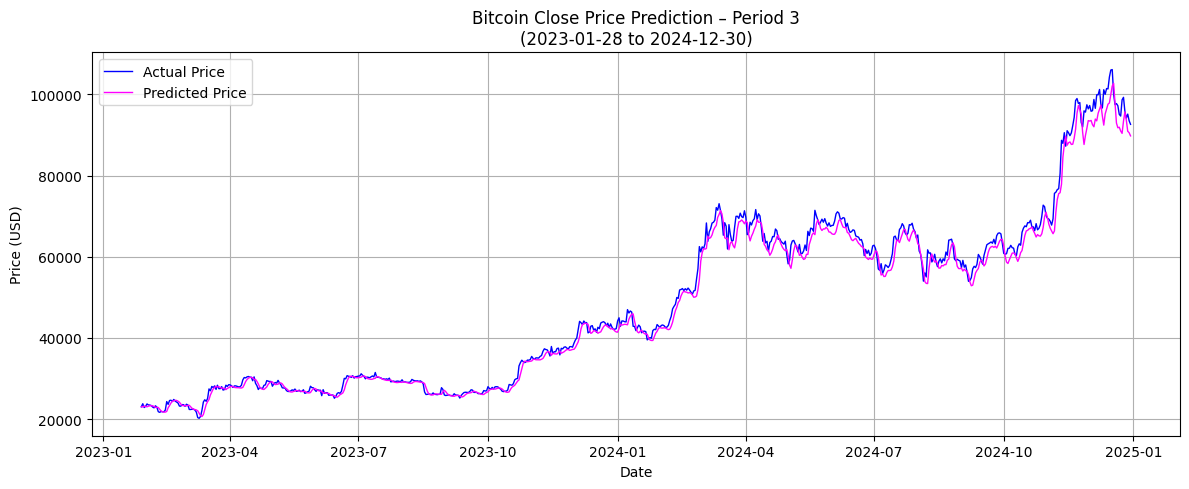


📊 Asset: Tesla
🔍 Period 1 with Vanilla LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


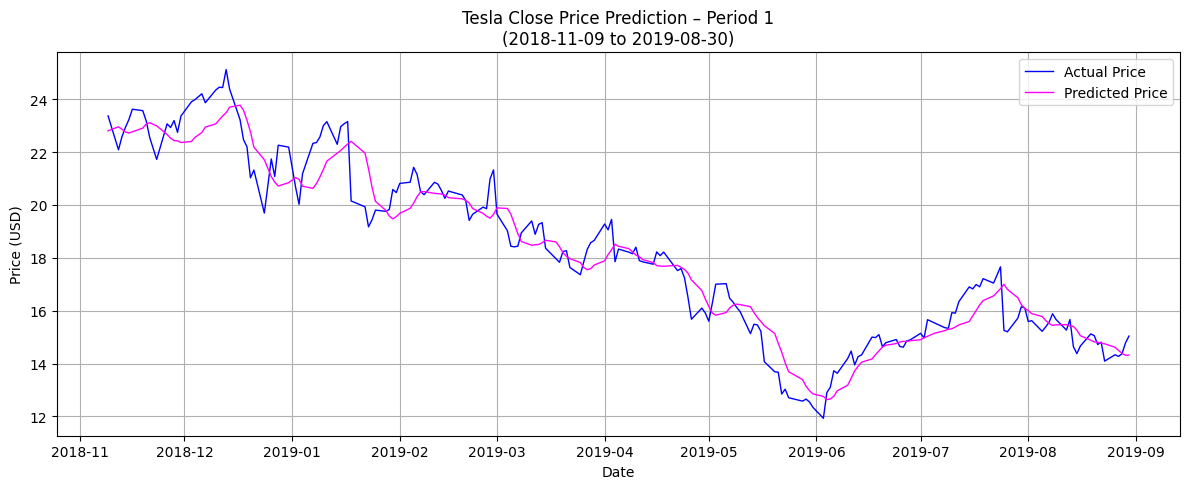

🔍 Period 2 with Vanilla LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


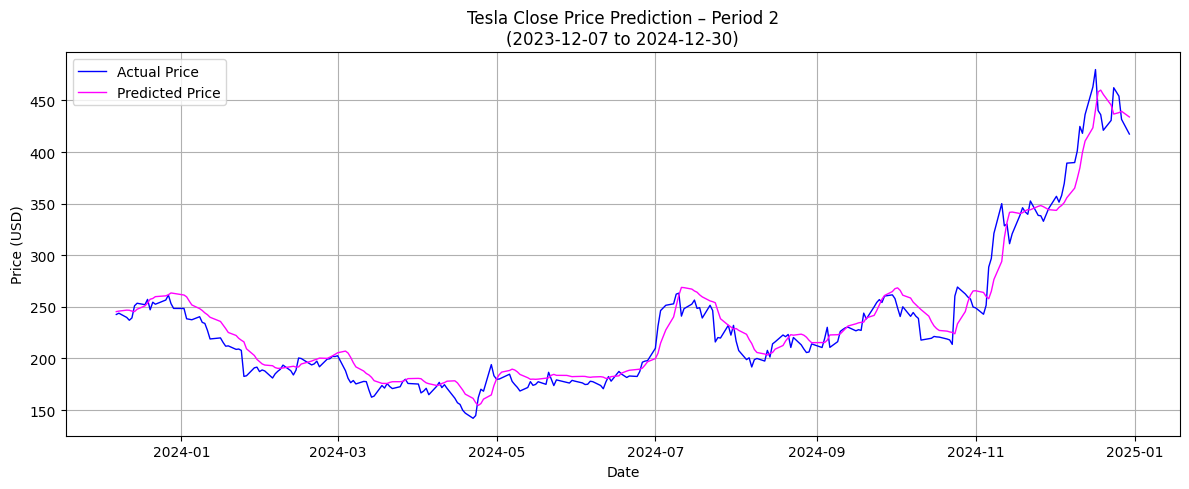

🔍 Period 3 with Stacked LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


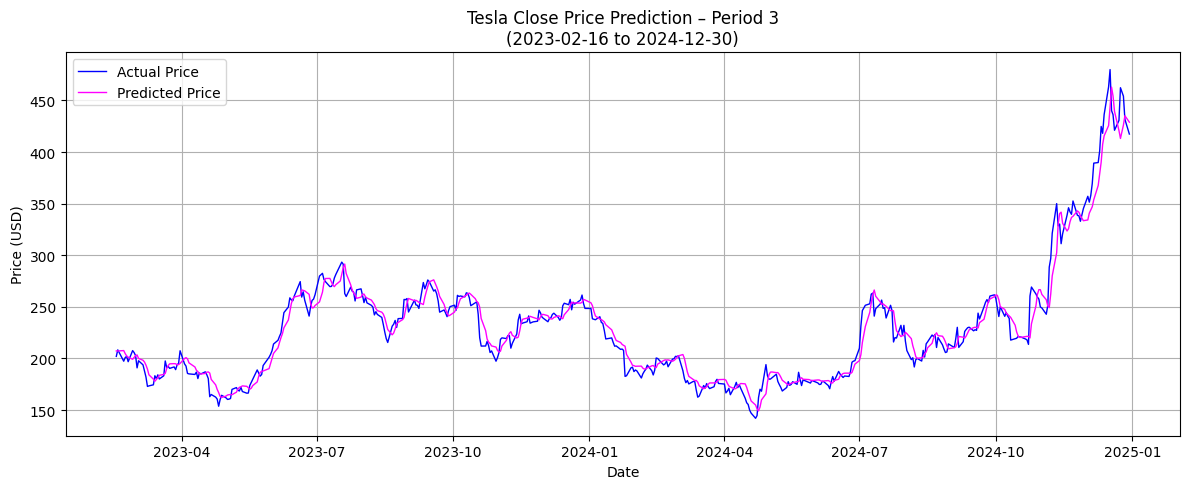

In [31]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ Global Periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# ✅ Best Features (common across assets)
features = ["Close", "Upper_BB", "Lower_BB"]

# ✅ LSTM type per period
model_structure = {
    "Period 1": "Vanilla",
    "Period 2": "Vanilla",
    "Period 3": "Stacked"
}

# ✅ Assets to process
assets = {
    "Bitcoin": pd.read_csv("bitcoin_features.csv", parse_dates=["Date"]),
    "Tesla": pd.read_csv("tesla_features.csv", parse_dates=["Date"])
}

# ✅ Set index and sort
for name, df in assets.items():
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    assets[name] = df

# ✅ Sequence Function
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# 🔁 Run for each asset and period
for asset_name, df in assets.items():
    print(f"\n📊 Asset: {asset_name}")

    for period, (start, end) in periods.items():
        print(f"🔍 {period} with {model_structure[period]} LSTM")

        df_period = df.loc[start:end, features].dropna().copy()
        df_period["Target"] = df_period["Close"]

        # Normalize
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_period)
        df_scaled = pd.DataFrame(scaled, columns=features + ["Target"], index=df_period.index)

        # Prepare sequences
        data = df_scaled.values
        X, y = create_sequences(data, seq_length=10)
        dates = df_scaled.index[10:]

        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = dates[split:]

        # Build model
        model = Sequential()
        model.add(LSTM(64, return_sequences=(model_structure[period] == "Stacked"), input_shape=(X.shape[1], X.shape[2])))
        if model_structure[period] == "Stacked":
            model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Train
        model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        # Predict
        y_pred = model.predict(X_test, verbose=0)
        y_test_inv = scaler.inverse_transform(np.hstack([np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)]))[:, -1]
        y_pred_inv = scaler.inverse_transform(np.hstack([np.zeros((len(y_pred), len(features))), y_pred]))[:, -1]

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(test_dates, y_test_inv, label='Actual Price', color='blue', linewidth=1)
        plt.plot(test_dates, y_pred_inv, label='Predicted Price', color='magenta', linewidth=1)
        plt.title(f"{asset_name} Close Price Prediction – {period}\n({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        fname = f"{asset_name.lower()}_price_prediction_{period.replace(' ', '_')}.png"
        plt.savefig(fname, dpi=300)
        plt.show()


In [32]:
import os
print("📁 Saved prediction plots:")
[print("-", f) for f in os.listdir() if f.endswith(".png") and "price_prediction" in f]


📁 Saved prediction plots:
- bitcoin_price_prediction_Period_2.png
- bitcoin_price_prediction_Period_3.png
- bitcoin_price_prediction_Period_1.png
- tesla_price_prediction_Period_2.png
- tesla_price_prediction_Period_3.png
- tesla_price_prediction_Period_1.png


[None, None, None, None, None, None]

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import glob
import os

# 🗂️ Collect all prediction plots for Bitcoin and Tesla
btc_files = sorted(glob.glob("bitcoin_price_prediction_Period_*.png"))
tsla_files = sorted(glob.glob("tesla_price_prediction_Period_*.png"))
plot_files = btc_files + tsla_files  # Combine both

# ✅ Output PDF file
pdf_filename = "BTC_TSLA_Prediction_Summary.pdf"

# 📄 Create PDF
with PdfPages(pdf_filename) as pdf:
    for file in plot_files:
        if os.path.exists(file):
            img = plt.imread(file)
            plt.figure(figsize=(12, 5))
            plt.imshow(img)
            plt.axis('off')
            title = file.replace("_", " ").replace(".png", "")
            plt.title(title, fontsize=12)
            pdf.savefig()
            plt.close()
        else:
            print(f"❌ File not found: {file}")

print(f"✅ PDF saved as: {pdf_filename}")


✅ PDF saved as: BTC_TSLA_Prediction_Summary.pdf


In [34]:
from google.colab import files
files.download("BTC_TSLA_Prediction_Summary.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 BTC | Period 1 — Differenced LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


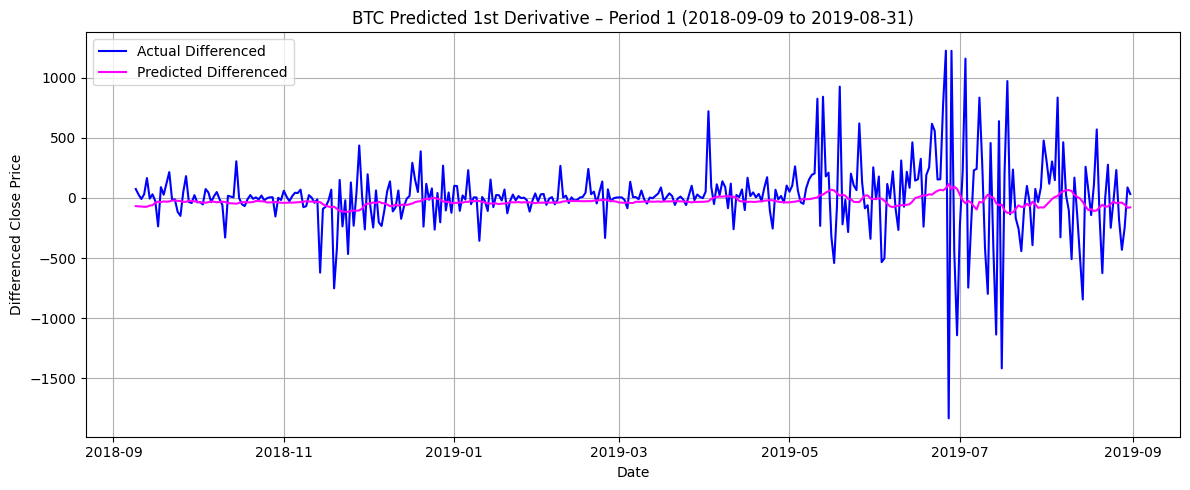

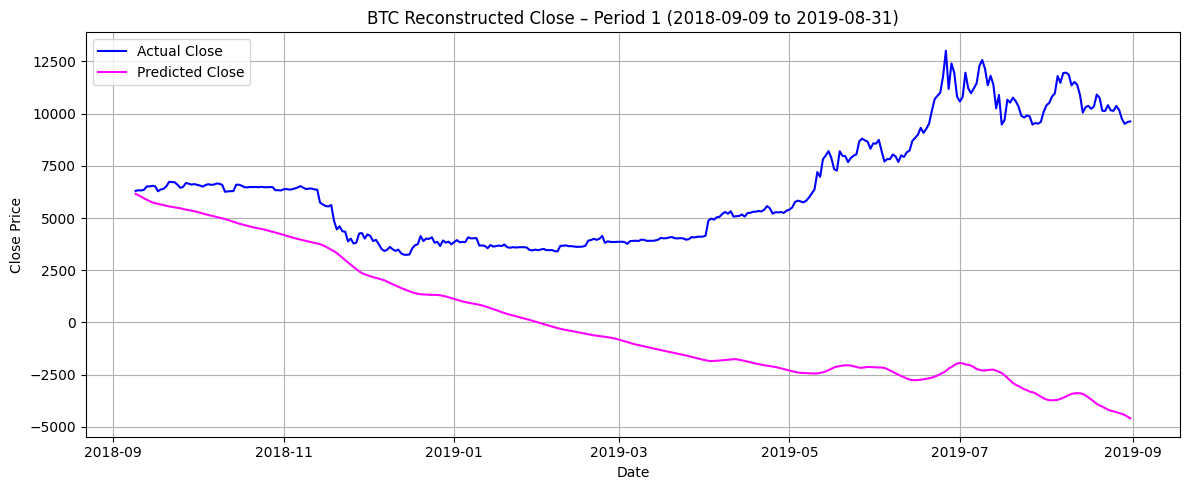

🚀 BTC | Period 2 — Differenced LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


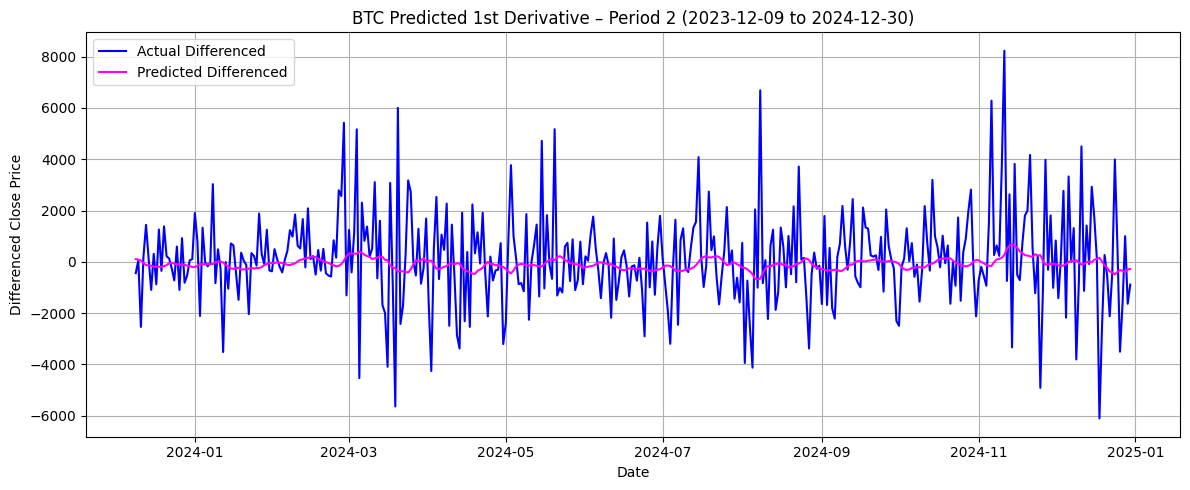

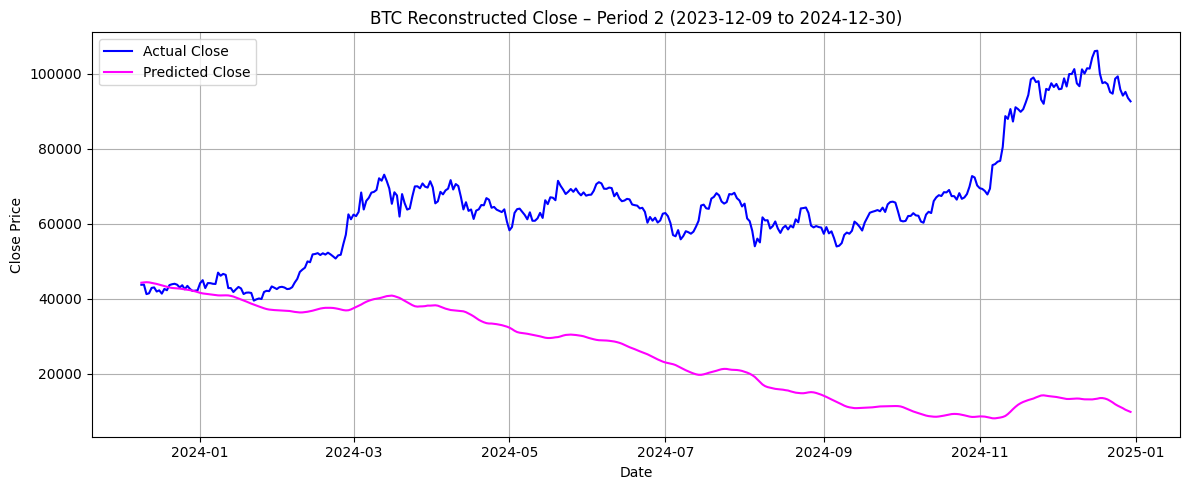

🚀 BTC | Period 3 — Differenced LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


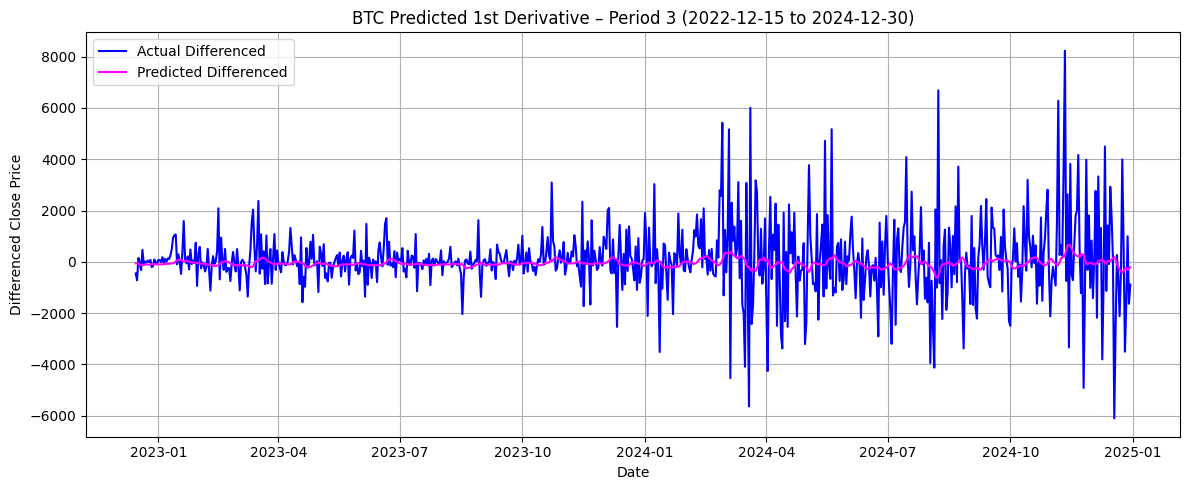

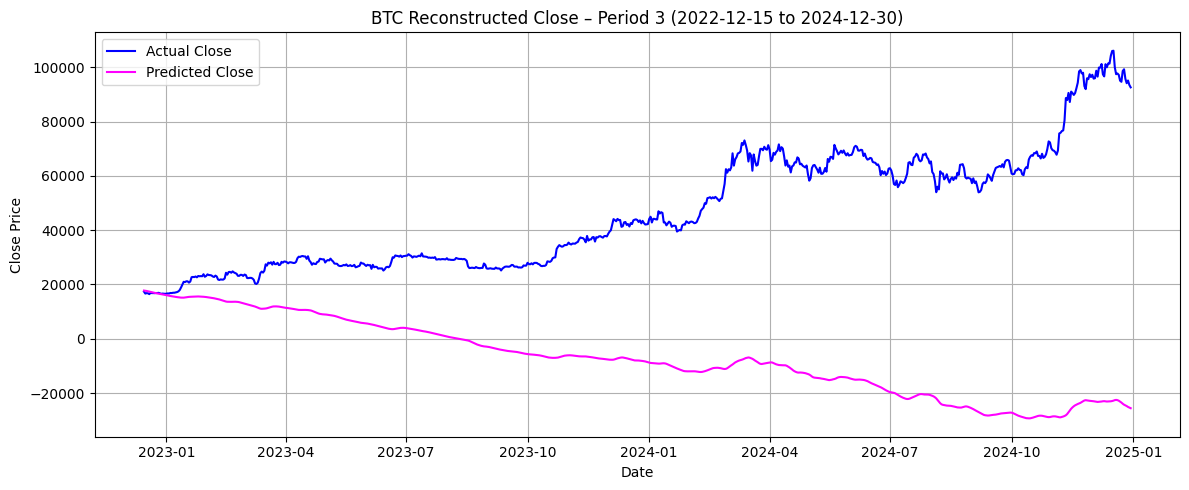

🚀 TSLA | Period 1 — Differenced LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


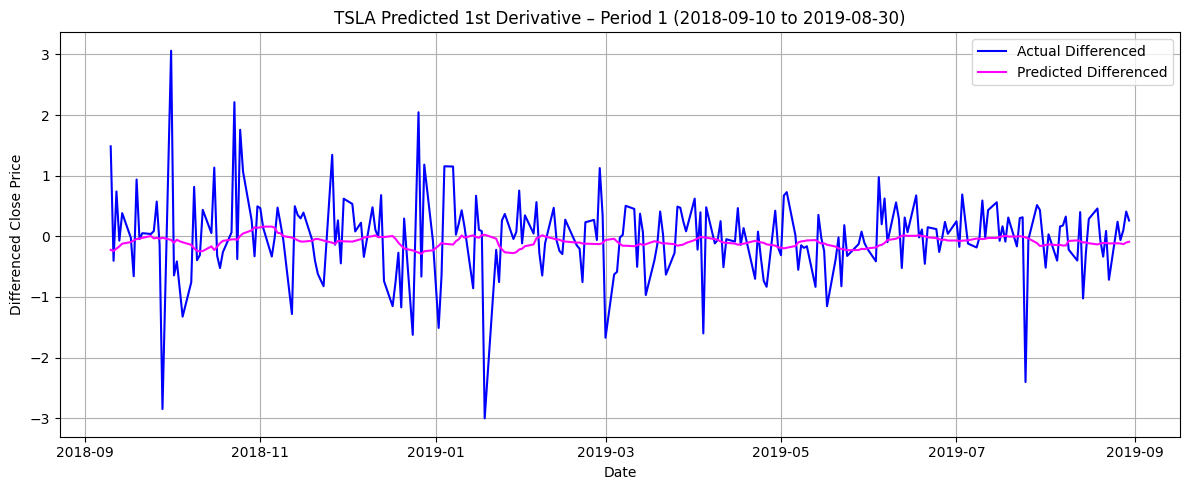

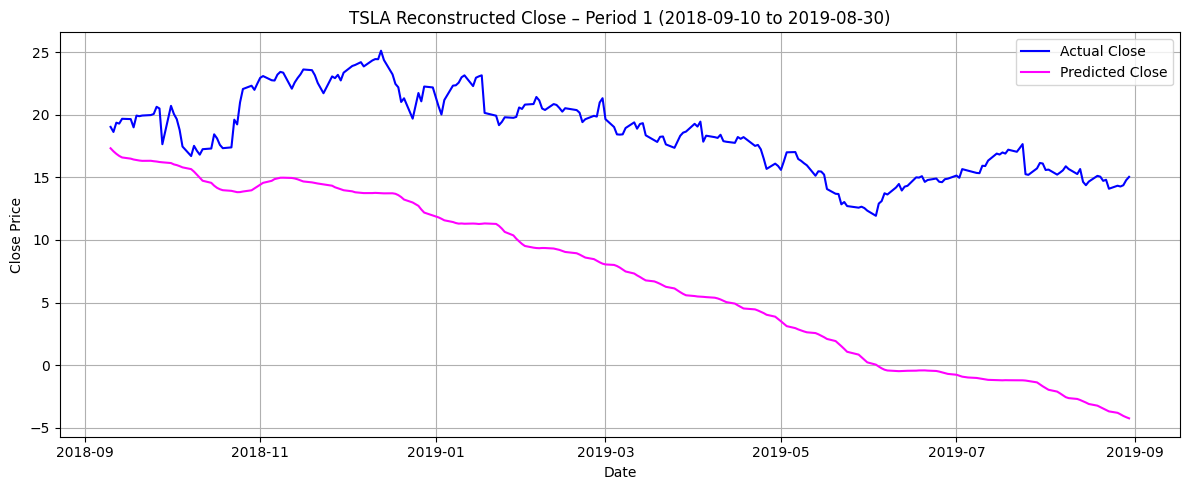

🚀 TSLA | Period 2 — Differenced LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


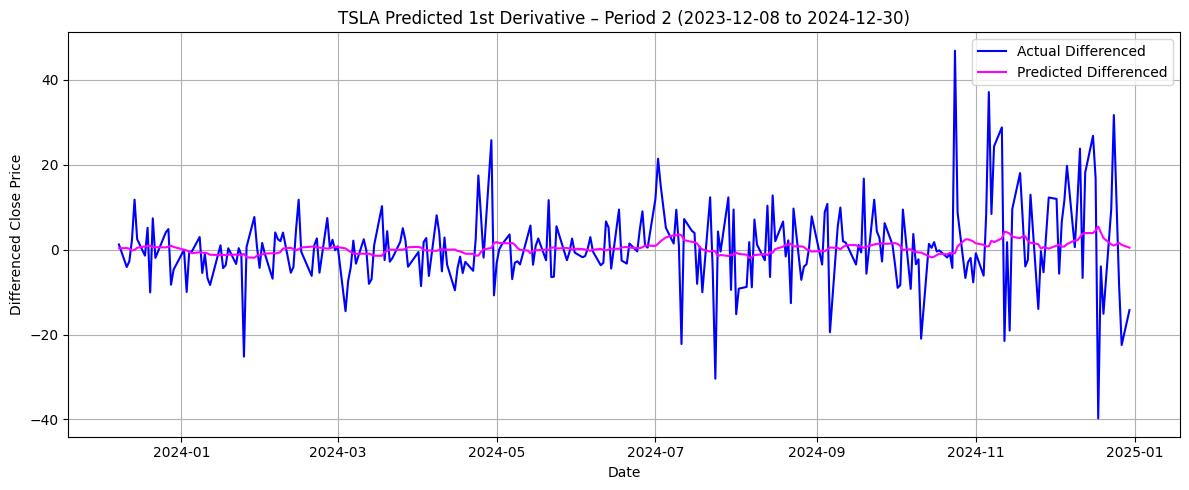

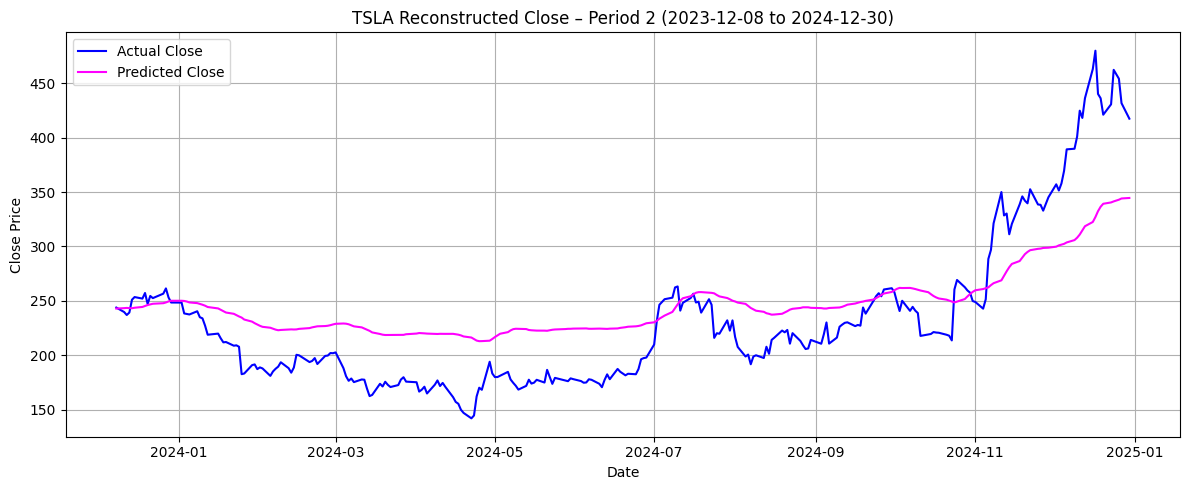

🚀 TSLA | Period 3 — Differenced LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


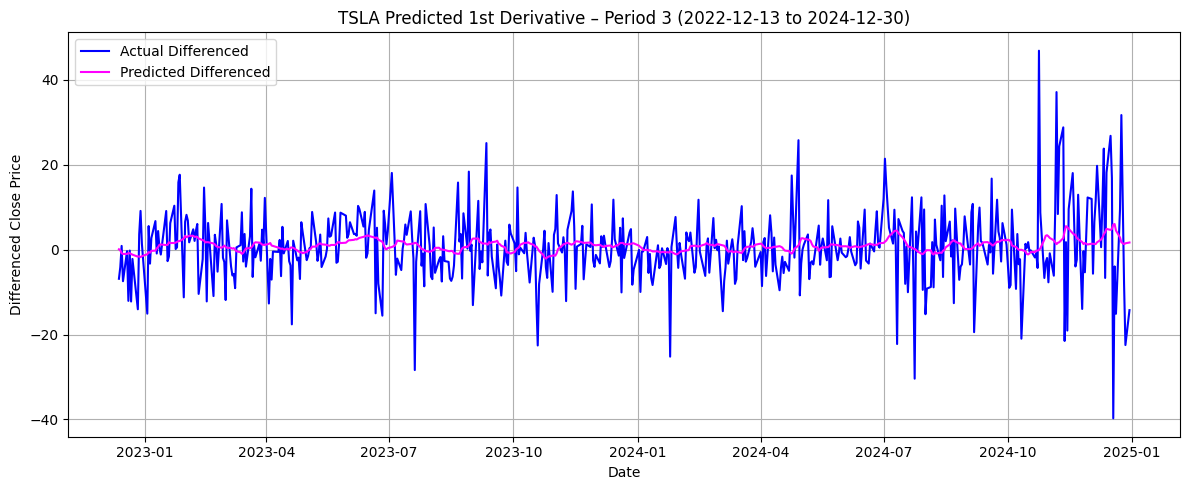

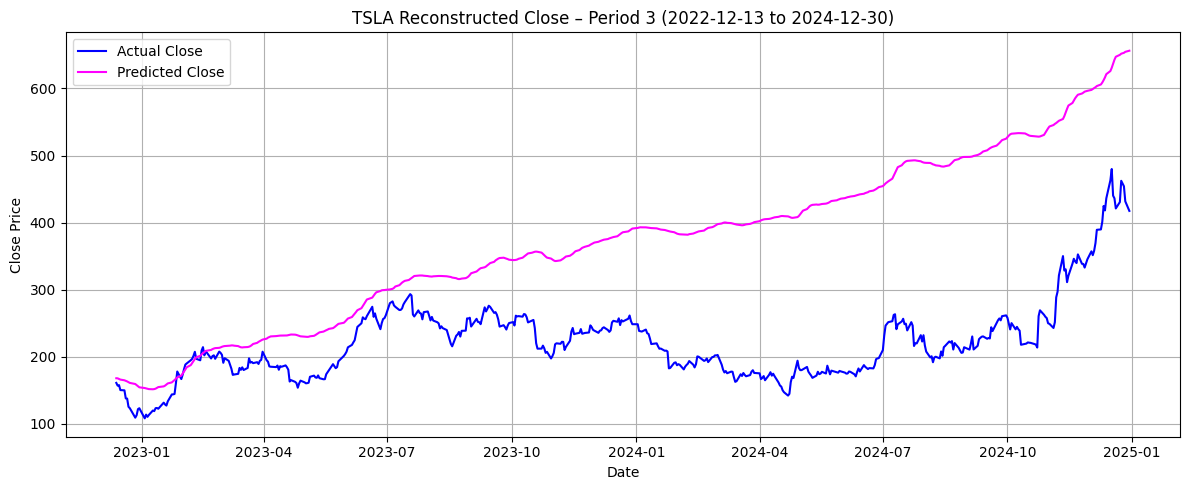

In [35]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 📅 Global Periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# 🧱 Sequence generator
def create_sequences(series, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

# 🗂️ Assets: Load and prepare
assets = {
    "BTC": pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True),
     "TSLA": pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
}

for name, df in assets.items():
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    assets[name] = df

# 🔁 Run Differenced LSTM for each asset and period
for asset_name, df in assets.items():
    for label, (start, end) in periods.items():
        print(f"🚀 {asset_name} | {label} — Differenced LSTM")

        # Subset and differencing
        df_period = df.loc[start:end].copy()
        df_period["diff_close"] = df_period["Close"].diff()
        df_period.dropna(inplace=True)

        # Scale differences
        scaler = MinMaxScaler()
        df_period["scaled_diff"] = scaler.fit_transform(df_period[["diff_close"]])

        # Sequence generation
        X, y = create_sequences(df_period["scaled_diff"].values.reshape(-1, 1))
        dates = df_period.index[10:]

        # Train/Test split
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = dates[split:]

        # LSTM model
        model = Sequential([
            LSTM(64, input_shape=(X.shape[1], 1)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        # Predict
        y_pred = model.predict(X_test)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # 🔹 Plot 1: Differenced Values
        plt.figure(figsize=(12, 5))
        plt.plot(test_dates, y_test_inv, label="Actual Differenced", color='blue')
        plt.plot(test_dates, y_pred_inv, label="Predicted Differenced", color='magenta')
        plt.title(f"{asset_name} Predicted 1st Derivative – {label} ({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Differenced Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset_name.lower()}_diff_{label.replace(' ', '_')}.png", dpi=300)
        plt.show()

        # 🔁 Reconstruct Close
        last_train_close = df_period["Close"].iloc[split + 10 - 1]
        pred_close = np.r_[last_train_close, y_pred_inv.flatten()].cumsum()[1:]
        actual_close = np.r_[last_train_close, y_test_inv.flatten()].cumsum()[1:]

        # 🔹 Plot 2: Reconstructed Close
        plt.figure(figsize=(12, 5))
        plt.plot(test_dates, actual_close, label="Actual Close", color='blue')
        plt.plot(test_dates, pred_close, label="Predicted Close", color='magenta')
        plt.title(f"{asset_name} Reconstructed Close – {label} ({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset_name.lower()}_diff_reconstructed_{label.replace(' ', '_')}.png", dpi=300)
        plt.show()



📊 Asset: BTC
🚀 Running LSTM on Differenced Data for BTC – Period 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


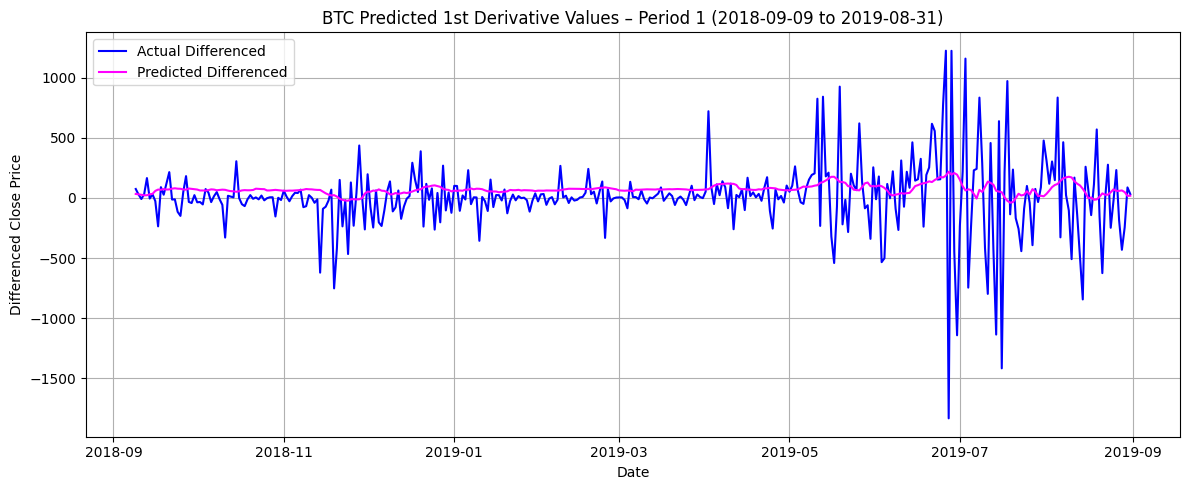

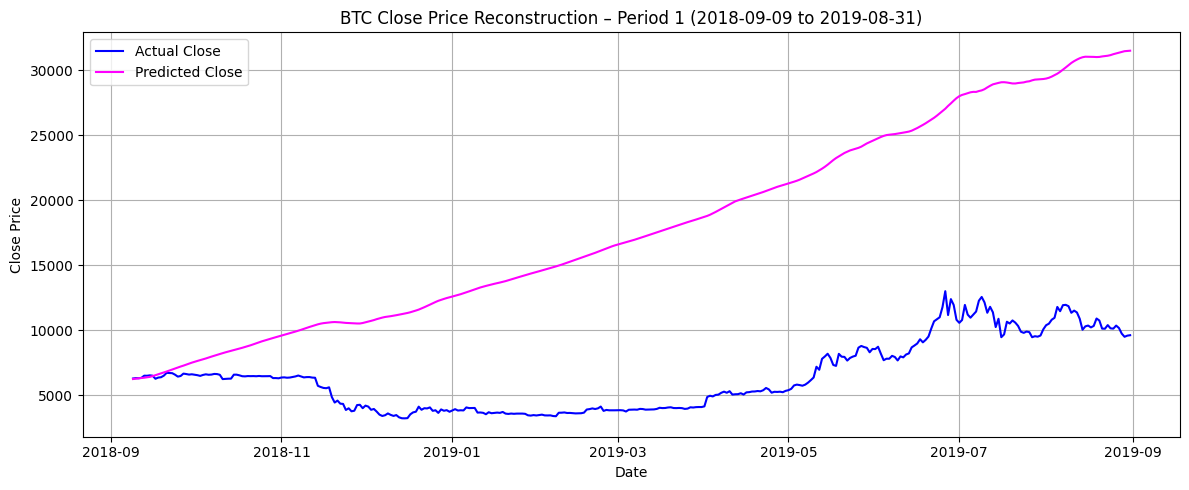

🚀 Running LSTM on Differenced Data for BTC – Period 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


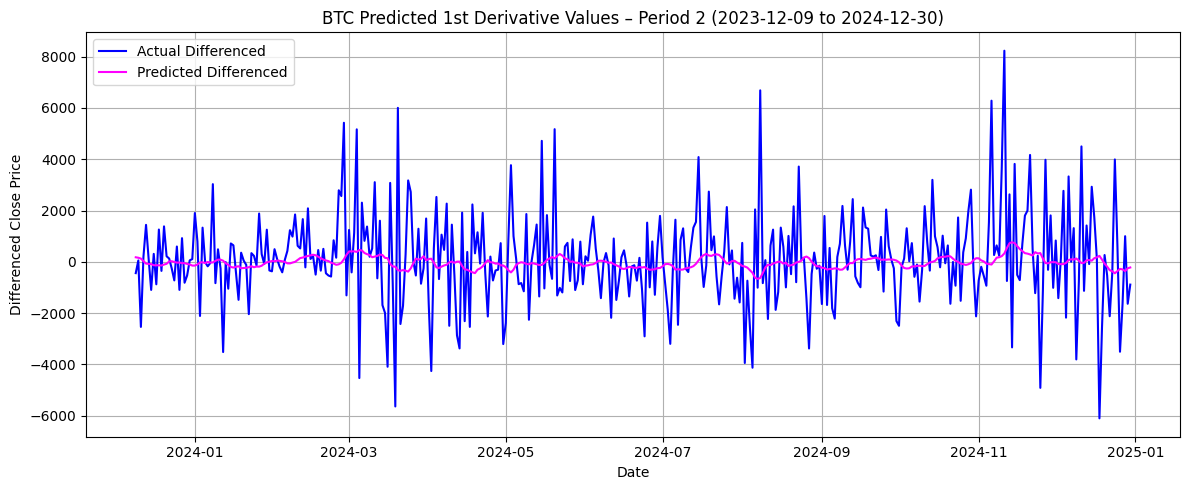

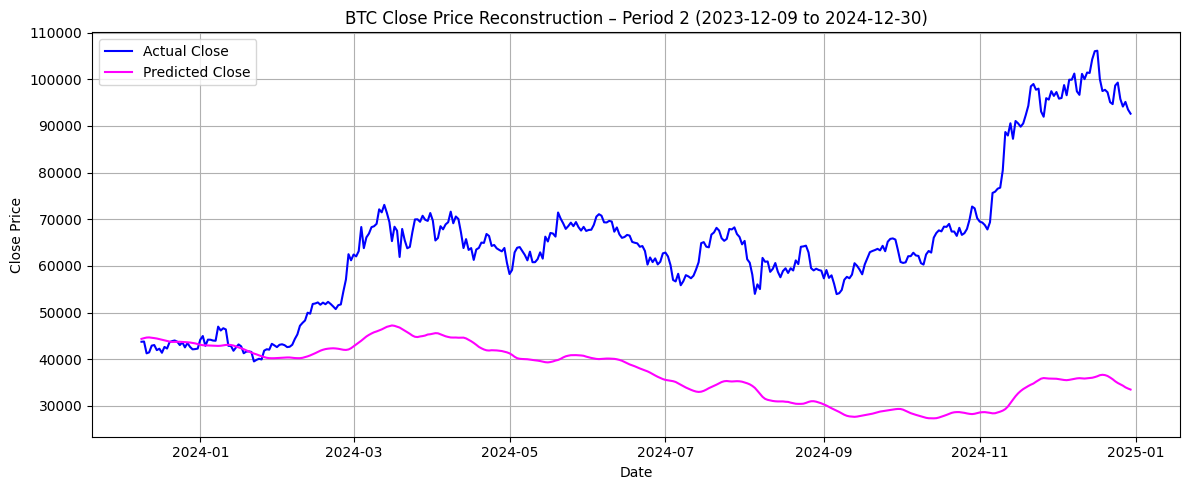

🚀 Running LSTM on Differenced Data for BTC – Period 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


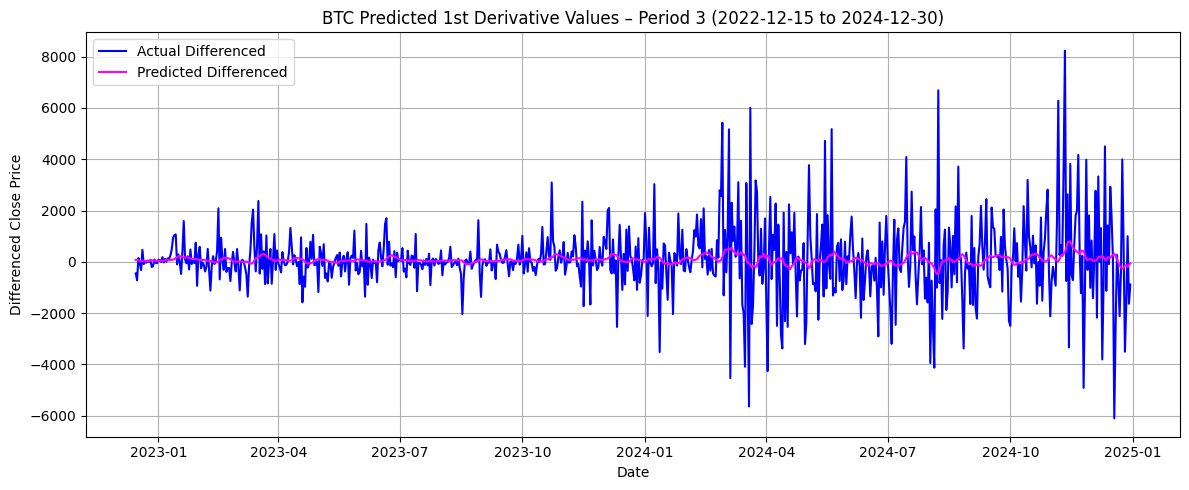

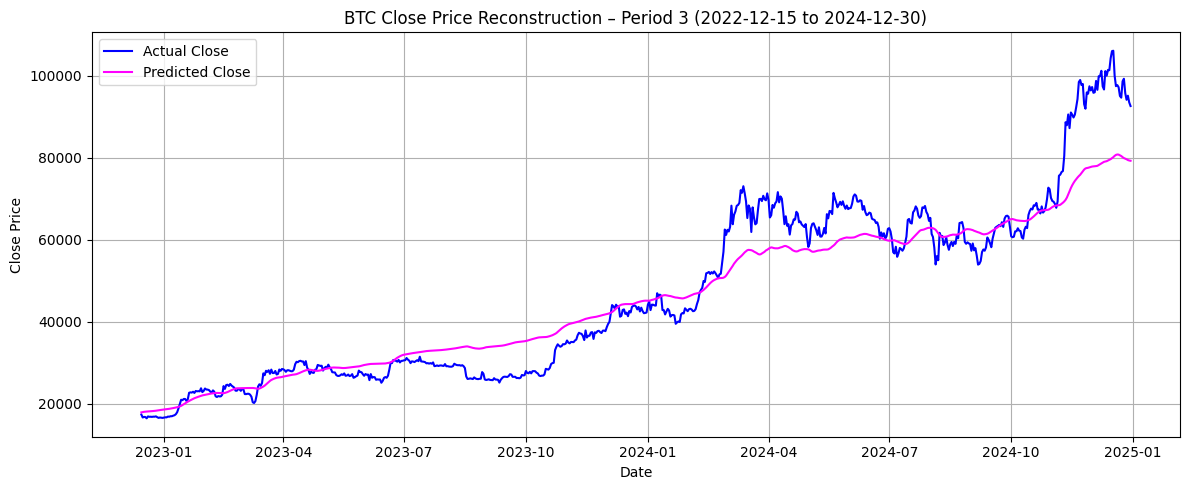


📊 Asset: TSLA
🚀 Running LSTM on Differenced Data for TSLA – Period 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


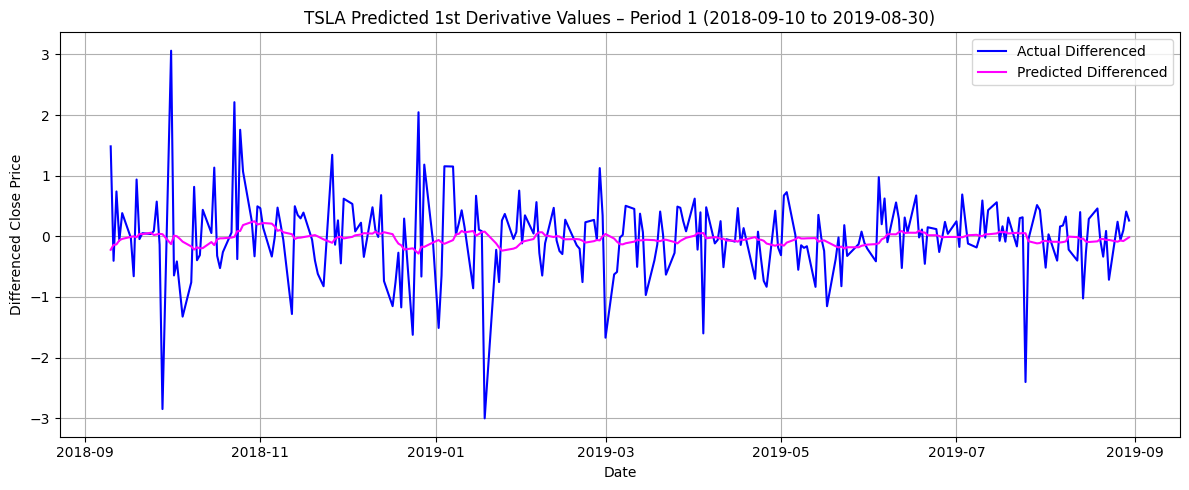

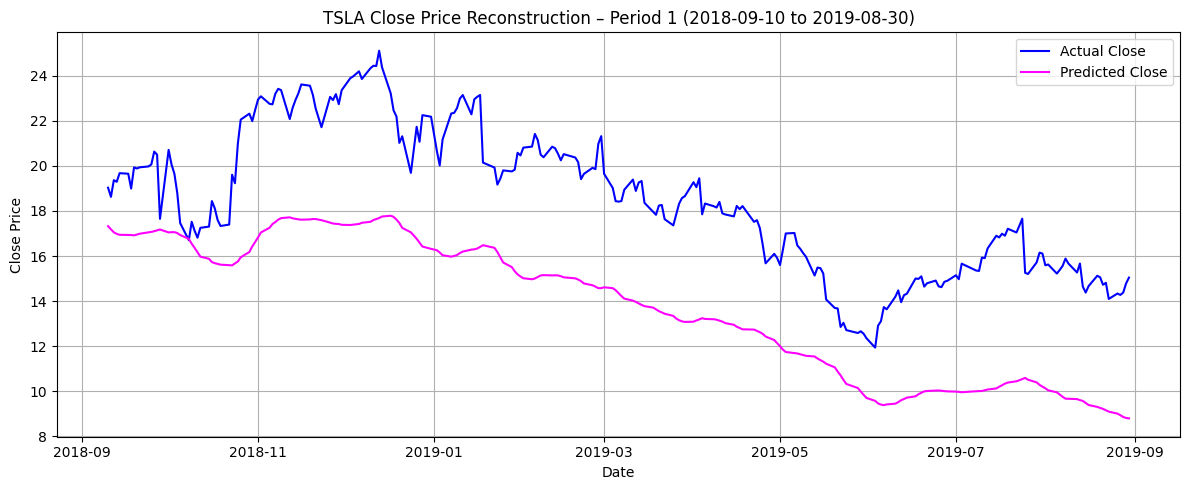

🚀 Running LSTM on Differenced Data for TSLA – Period 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


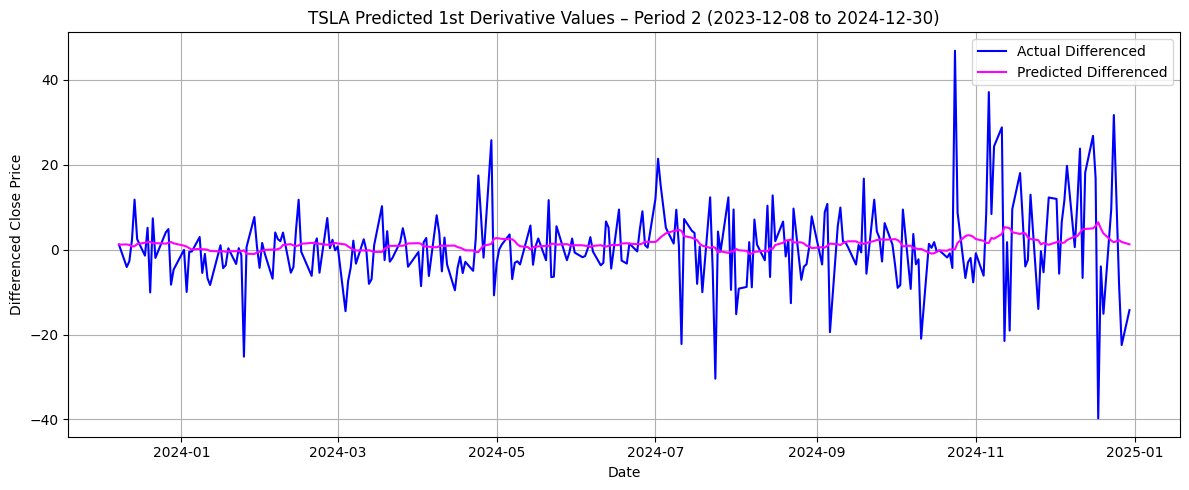

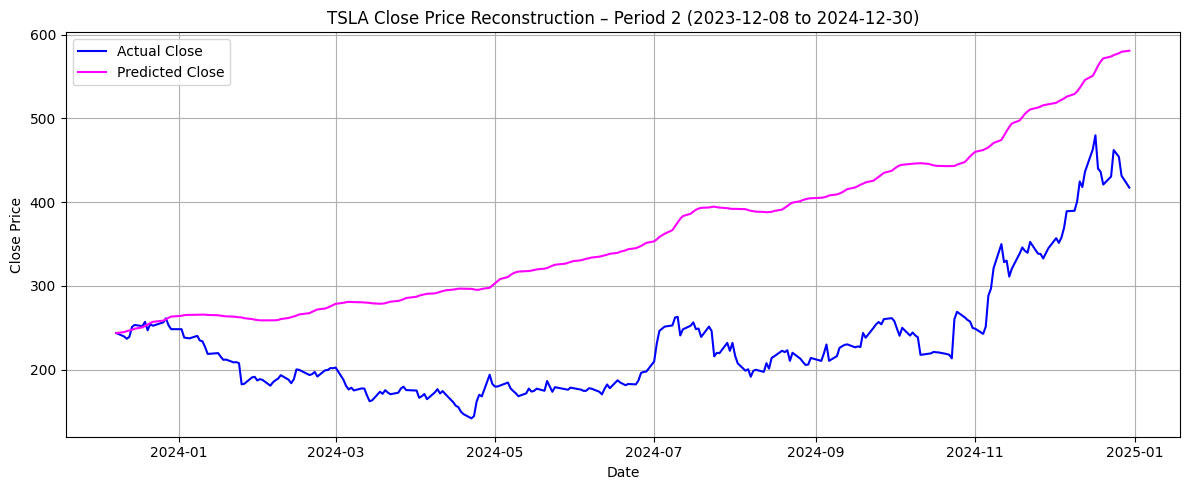

🚀 Running LSTM on Differenced Data for TSLA – Period 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


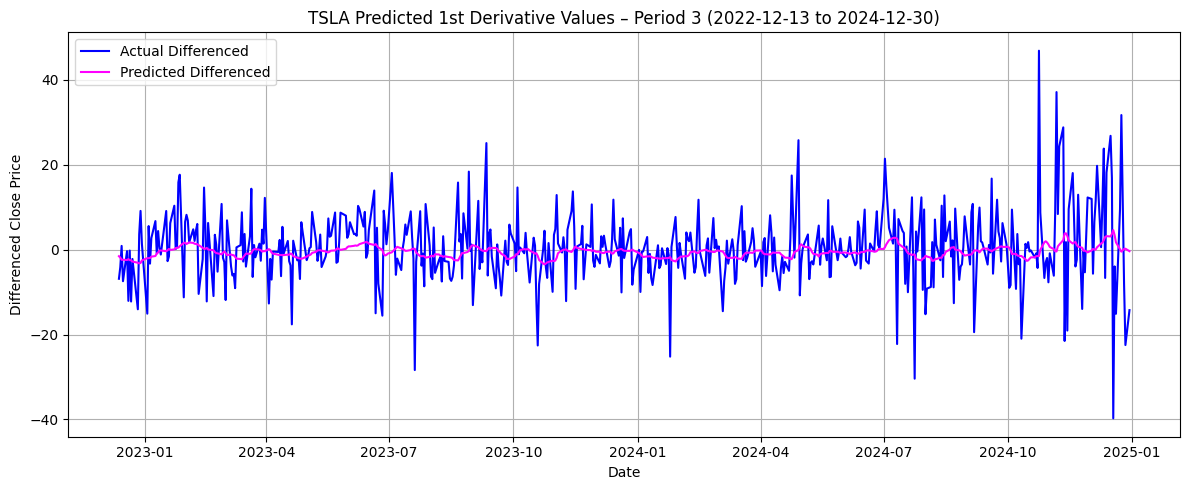

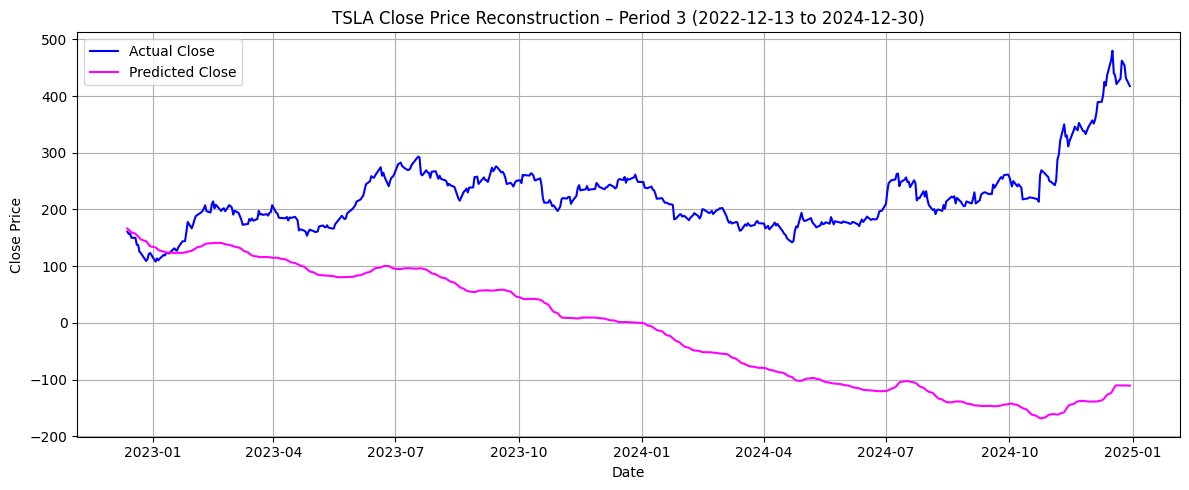

In [36]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🗂️ Load and preprocess data for both assets
assets = {
    "BTC": pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True),
    "TSLA": pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
}

# ✅ Preprocess: set index and sort
for name in assets:
    assets[name].set_index("Date", inplace=True)
    assets[name].sort_index(inplace=True)

# 📅 Global periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# ✅ Sequence builder
def create_sequences(series, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

# 🔁 Loop through both assets and each period
for asset_name, df in assets.items():
    print(f"\n📊 Asset: {asset_name}")

    for label, (start, end) in periods.items():
        print(f"🚀 Running LSTM on Differenced Data for {asset_name} – {label}")

        df_period = df.loc[start:end].copy()
        df_period["diff_close"] = df_period["Close"].diff()
        df_period.dropna(inplace=True)

        # Normalize differenced values
        scaler = MinMaxScaler()
        df_period["scaled_diff"] = scaler.fit_transform(df_period[["diff_close"]])

        # Sequences
        seq_len = 10
        X, y = create_sequences(df_period["scaled_diff"].values.reshape(-1, 1), seq_len)
        dates = df_period.index[seq_len:]

        # Train/test split
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = dates[split:]

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(64, input_shape=(seq_len, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        # Predict
        y_pred = model.predict(X_test)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # 🔹 Plot 1: Differenced values
        plt.figure(figsize=(12,5))
        plt.plot(test_dates, y_test_inv, label="Actual Differenced", color='blue')
        plt.plot(test_dates, y_pred_inv, label="Predicted Differenced", color='magenta')
        plt.title(f"{asset_name} Predicted 1st Derivative Values – {label} ({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Differenced Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset_name.lower()}_diff_{label.replace(' ', '_')}.png", dpi=300)
        plt.show()

        # 🔁 Reconstruct close prices from differenced predictions
        last_train_close = df_period["Close"].iloc[split + seq_len - 1]
        pred_close = np.r_[last_train_close, y_pred_inv.flatten()].cumsum()[1:]
        actual_close = np.r_[last_train_close, y_test_inv.flatten()].cumsum()[1:]

        # 🔹 Plot 2: Reconstructed Close Prices
        plt.figure(figsize=(12,5))
        plt.plot(test_dates, actual_close, label="Actual Close", color='blue')
        plt.plot(test_dates, pred_close, label="Predicted Close", color='magenta')
        plt.title(f"{asset_name} Close Price Reconstruction – {label} ({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset_name.lower()}_diff_reconstructed_{label.replace(' ', '_')}.png", dpi=300)
        plt.show()


In [37]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import glob
from google.colab import files

# 🔍 Find all BTC and TSLA differenced plot files
btc_files = sorted(glob.glob("btc_diff_*.png"))
tsla_files = sorted(glob.glob("tsla_diff_*.png"))
btc_reconstructed = sorted(glob.glob("btc_diff_reconstructed_*.png"))
tsla_reconstructed = sorted(glob.glob("tsla_diff_reconstructed_*.png"))

# Combine all into one list
diff_plot_files = btc_files + tsla_files + btc_reconstructed + tsla_reconstructed

# ✅ Output PDF file name
pdf_filename = "BTC_TSLA_Differenced_LSTM_Summary.pdf"

# 📄 Generate PDF with all differenced plots
with PdfPages(pdf_filename) as pdf:
    for file in diff_plot_files:
        img = plt.imread(file)
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(file.replace("_", " ").replace(".png", ""), fontsize=12)
        pdf.savefig(fig)
        plt.close(fig)

print(f"✅ PDF saved as: {pdf_filename}")

# ⬇️ Trigger browser download
files.download(pdf_filename)


✅ PDF saved as: BTC_TSLA_Differenced_LSTM_Summary.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# 📦 Load required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ Load datasets
assets = {
    "Bitcoin": pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"]),
    "Tesla": pd.read_csv("Tesla_stock.csv", parse_dates=["Date"])
}

# ✅ Standard period for both
period_start, period_end = "2014-10-01", "2019-08-31"

# 🔁 Store results
predictions = {}

# ✅ Sequence generation function
def create_sequences(series, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

# 🔁 Loop over each asset
for name, df in assets.items():
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    df_period = df.loc[period_start:period_end].copy()

    # 🚫 Skip if no data
    if df_period.empty:
        print(f"⚠️ Skipping {name}: No data found for the selected period.")
        continue

    # 📊 Scale 'Close'
    scaler = MinMaxScaler()
    df_period["Close_scaled"] = scaler.fit_transform(df_period[["Close"]])

    # 🔁 Generate sequences
    seq_len = 10
    X, y = create_sequences(df_period["Close_scaled"].values.reshape(-1, 1), seq_len)
    dates = df_period.index[seq_len:]

    if len(X) == 0:
        print(f"⚠️ Skipping {name}: Not enough data to generate sequences.")
        continue

    # 📉 Train-test split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_dates = dates[split_idx:]

    # 🧠 Build model
    model = Sequential([
        LSTM(64, input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # 🚀 Train
    model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )

    # 📈 Predict
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # 📦 Store for plotting or metrics
    predictions[name] = {
        "dates": test_dates,
        "y_true": y_test_inv,
        "y_pred": y_pred_inv
    }

print("\n✅ Completed training and prediction for available assets.")


<ipython-input-38-e7fb14f321c8>:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  "Bitcoin": pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"]),
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
⚠️ Skipping Tesla: No data found for the selected period.

✅ Completed training and prediction for available assets.



📊 Asset: BTC
🚀 Running LSTM on Differenced Data for BTC – Period 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


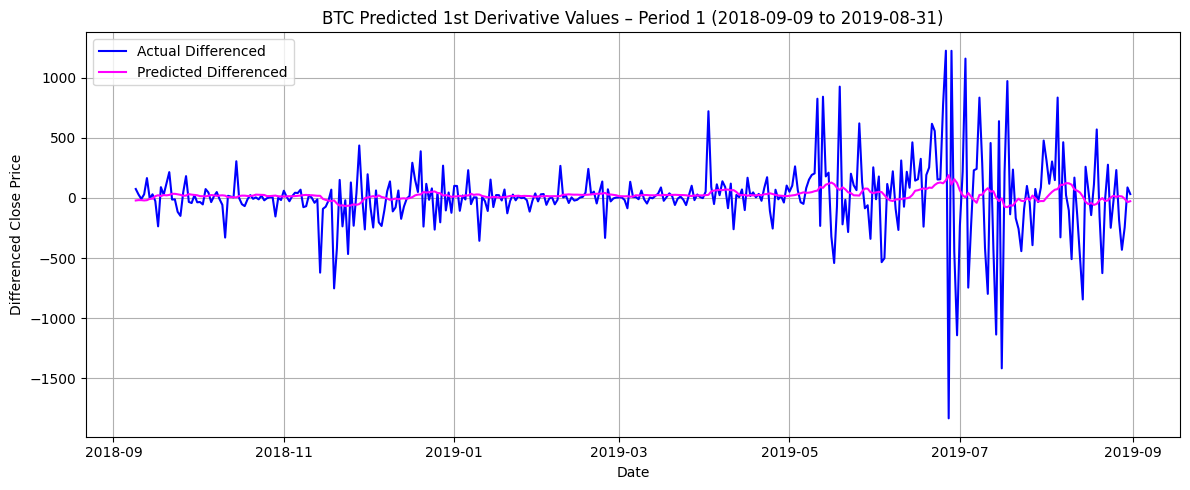

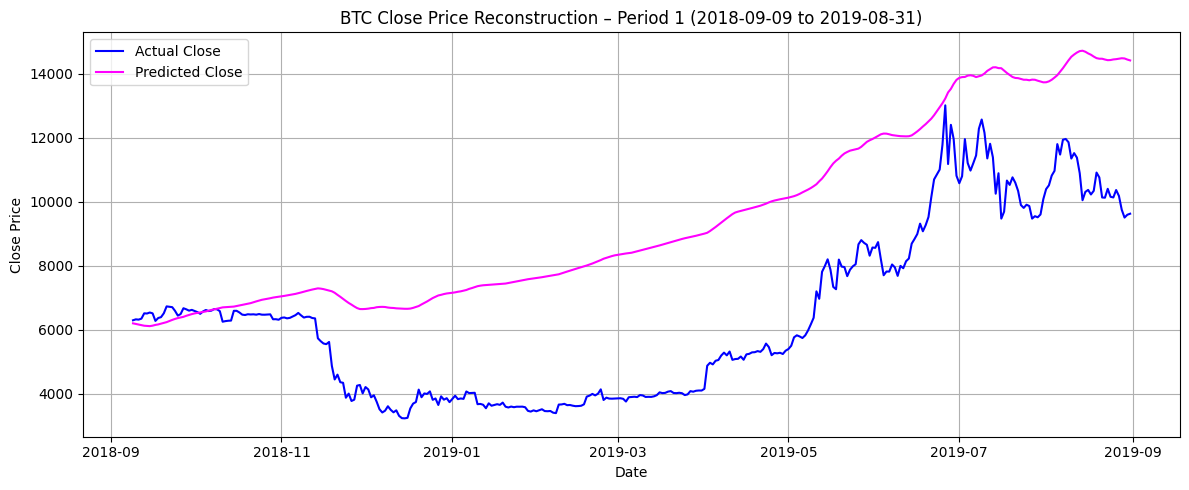

🚀 Running LSTM on Differenced Data for BTC – Period 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


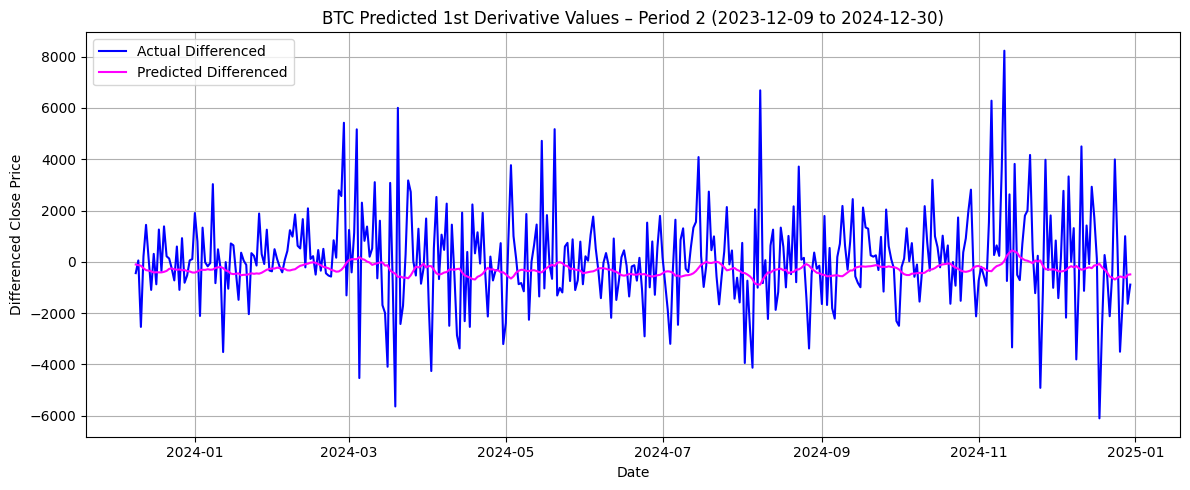

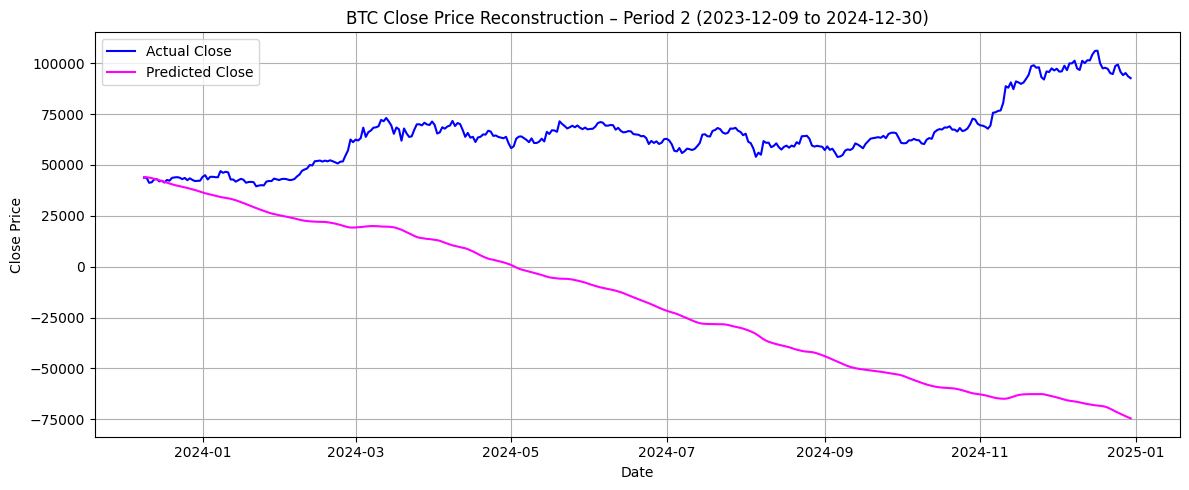

🚀 Running LSTM on Differenced Data for BTC – Period 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


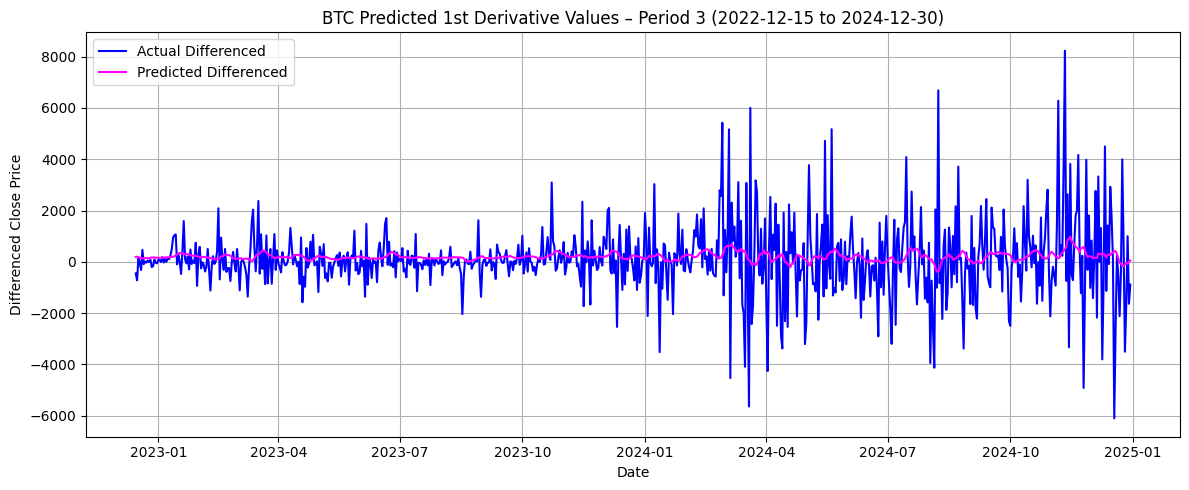

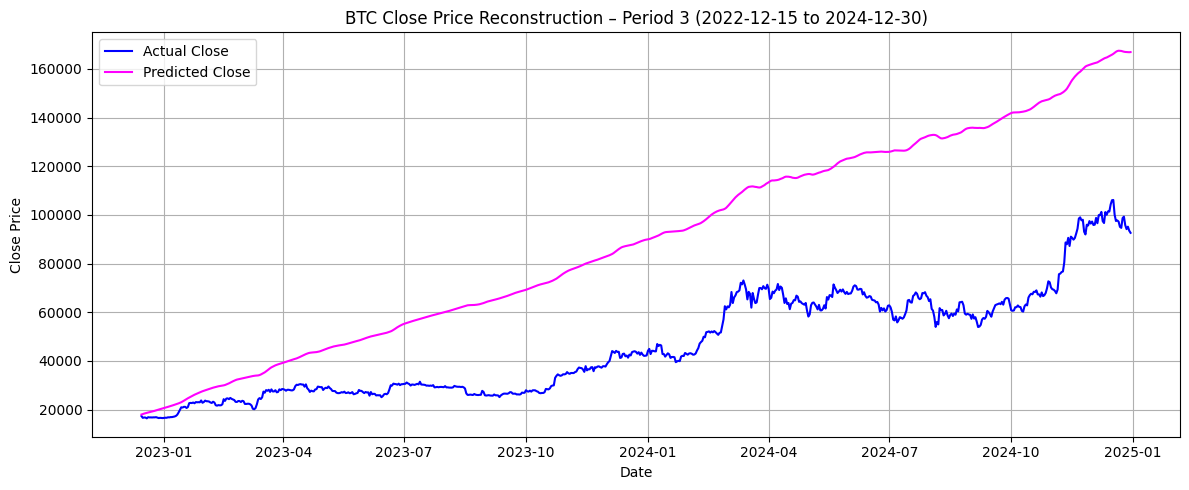


📊 Asset: TSLA
🚀 Running LSTM on Differenced Data for TSLA – Period 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


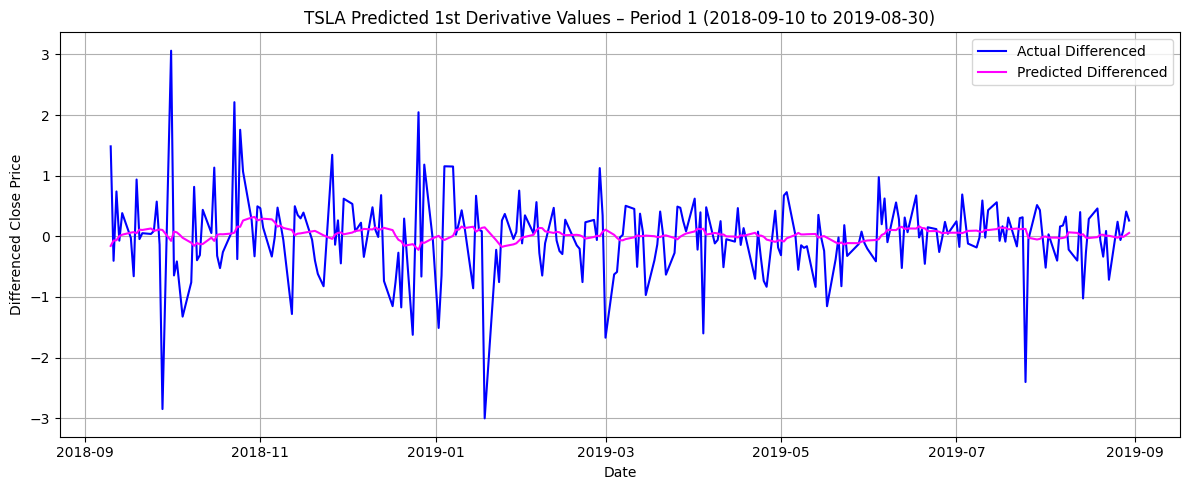

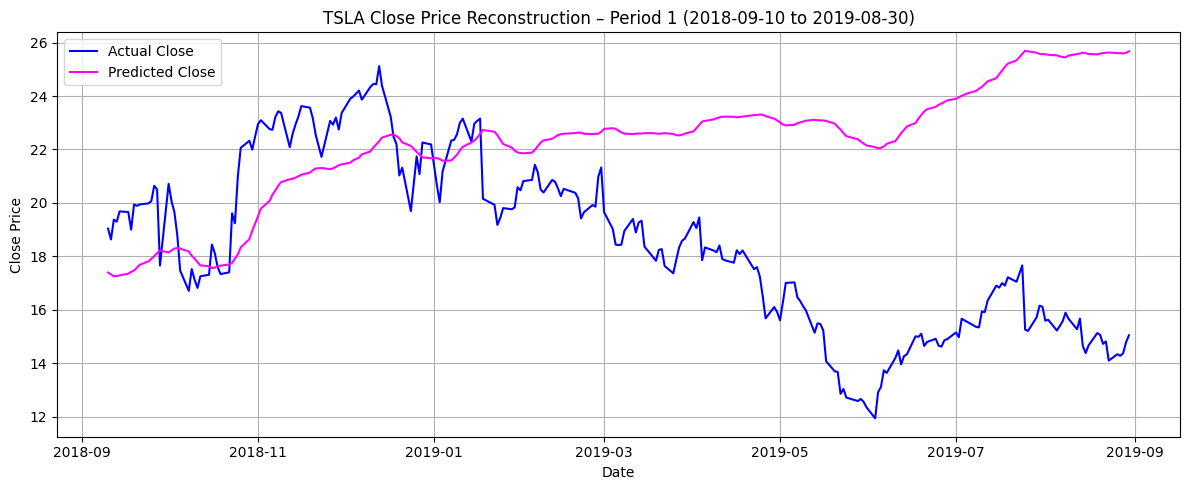

🚀 Running LSTM on Differenced Data for TSLA – Period 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


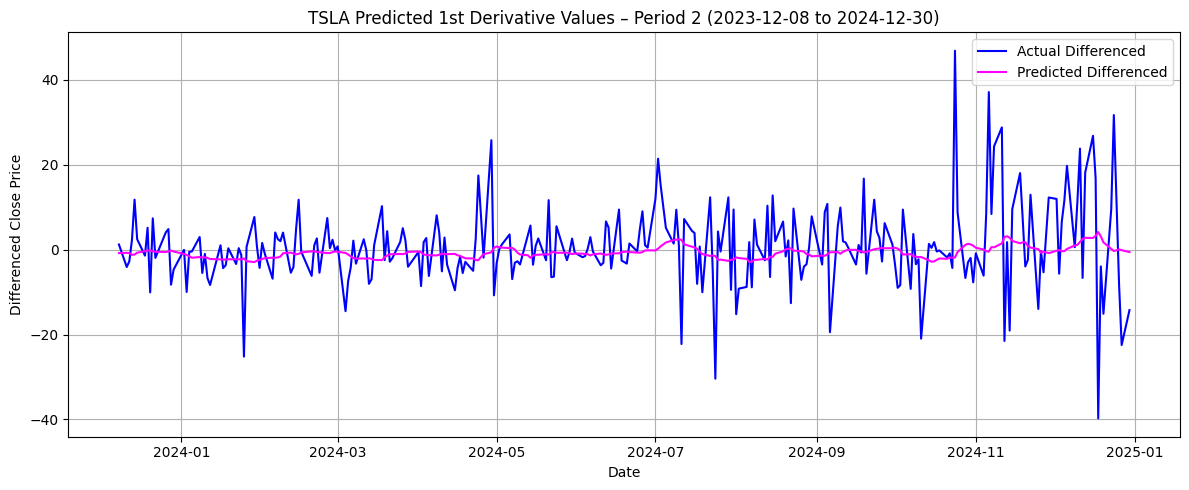

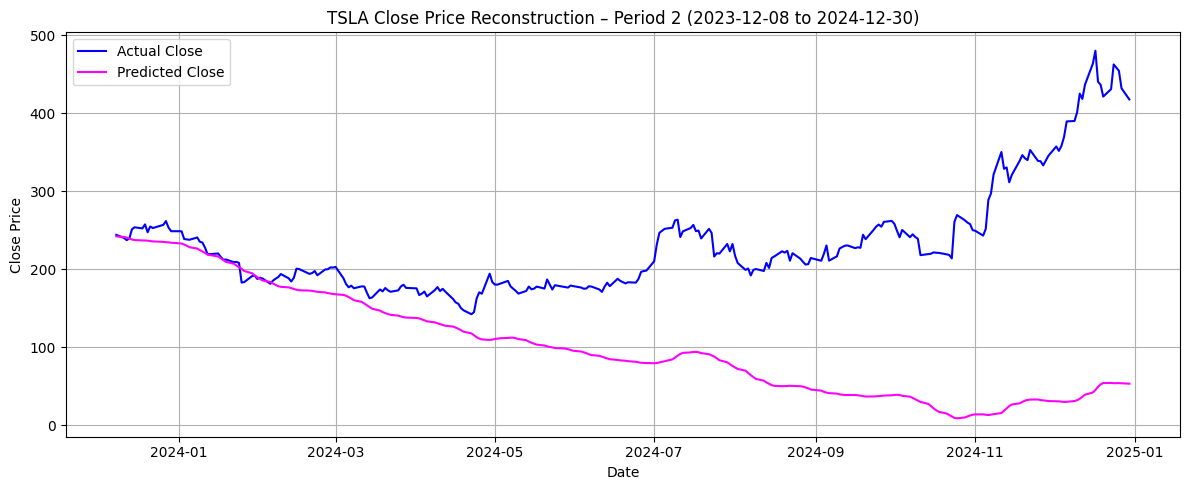

🚀 Running LSTM on Differenced Data for TSLA – Period 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


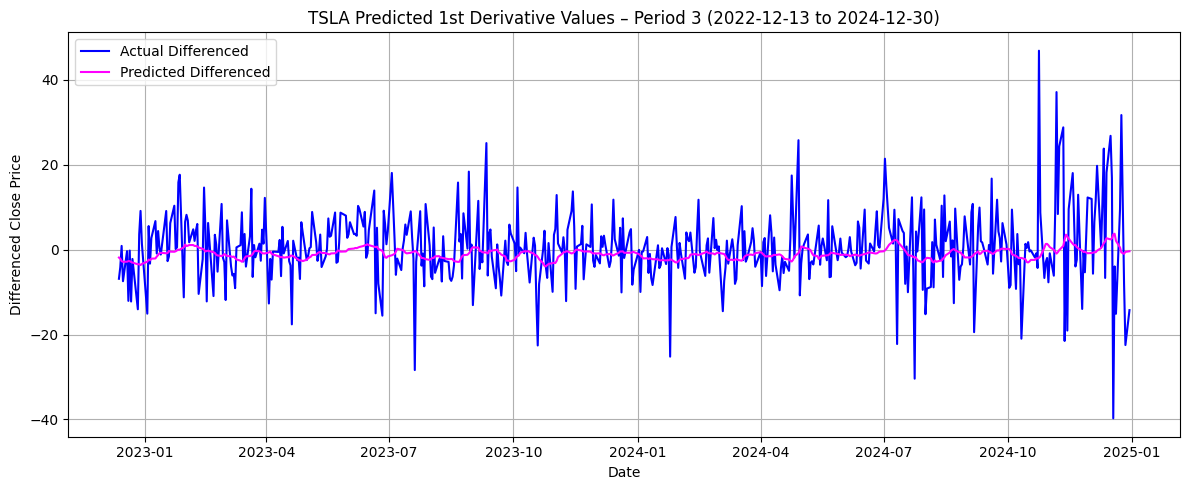

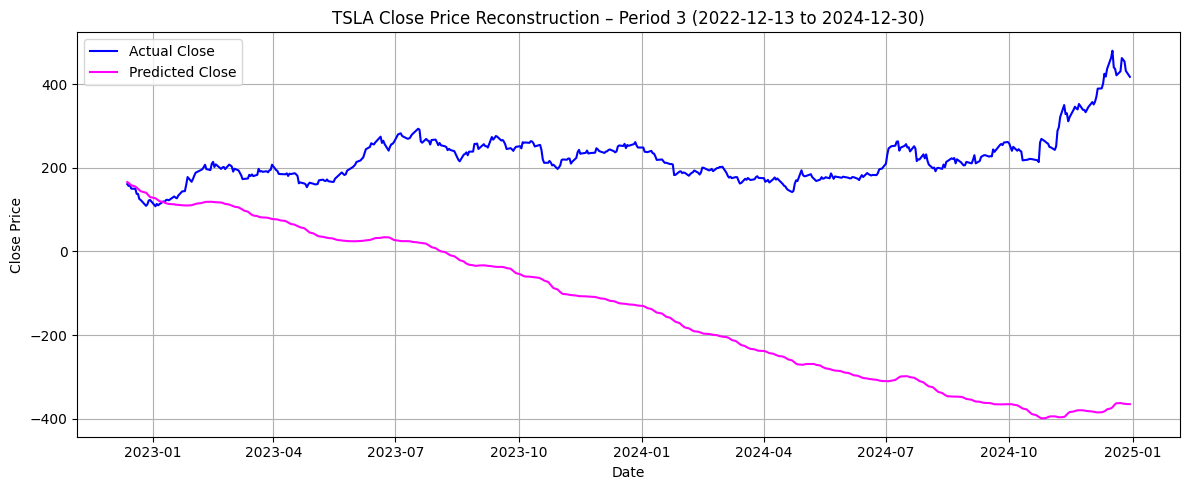

In [39]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🗂️ Load and preprocess data for both assets
assets = {
    "BTC": pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True),
    "TSLA": pd.read_csv("Tesla_stock.csv", parse_dates=["Date"], dayfirst=True)
}

# ✅ Preprocess: set index and sort
for name in assets:
    assets[name].set_index("Date", inplace=True)
    assets[name].sort_index(inplace=True)

# 📅 Global periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# ✅ Sequence builder
def create_sequences(series, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

# 🔁 Loop through both assets and each period
for asset_name, df in assets.items():
    print(f"\n📊 Asset: {asset_name}")

    for label, (start, end) in periods.items():
        print(f"🚀 Running LSTM on Differenced Data for {asset_name} – {label}")

        df_period = df.loc[start:end].copy()
        df_period["diff_close"] = df_period["Close"].diff()
        df_period.dropna(inplace=True)

        # Normalize differenced values
        scaler = MinMaxScaler()
        df_period["scaled_diff"] = scaler.fit_transform(df_period[["diff_close"]])

        # Sequences
        seq_len = 10
        X, y = create_sequences(df_period["scaled_diff"].values.reshape(-1, 1), seq_len)
        dates = df_period.index[seq_len:]

        # Train/test split
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = dates[split:]

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(64, input_shape=(seq_len, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        # Predict
        y_pred = model.predict(X_test)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # 🔹 Plot 1: Differenced values
        plt.figure(figsize=(12,5))
        plt.plot(test_dates, y_test_inv, label="Actual Differenced", color='blue')
        plt.plot(test_dates, y_pred_inv, label="Predicted Differenced", color='magenta')
        plt.title(f"{asset_name} Predicted 1st Derivative Values – {label} ({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Differenced Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset_name.lower()}_diff_{label.replace(' ', '_')}.png", dpi=300)
        plt.show()

        # 🔁 Reconstruct close prices from differenced predictions
        last_train_close = df_period["Close"].iloc[split + seq_len - 1]
        pred_close = np.r_[last_train_close, y_pred_inv.flatten()].cumsum()[1:]
        actual_close = np.r_[last_train_close, y_test_inv.flatten()].cumsum()[1:]

        # 🔹 Plot 2: Reconstructed Close Prices
        plt.figure(figsize=(12,5))
        plt.plot(test_dates, actual_close, label="Actual Close", color='blue')
        plt.plot(test_dates, pred_close, label="Predicted Close", color='magenta')
        plt.title(f"{asset_name} Close Price Reconstruction – {label} ({test_dates.min().date()} to {test_dates.max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{asset_name.lower()}_diff_reconstructed_{label.replace(' ', '_')}.png", dpi=300)
        plt.show()


In [40]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import glob
from google.colab import files

# 🔍 Find all prediction images
plot_files = sorted(glob.glob("*diff_reconstructed_*.png"))  # or adjust pattern to match your files
pdf_filename = "Reconstructed_LSTM_Predictions.pdf"

# 📄 Create PDF
with PdfPages(pdf_filename) as pdf:
    for file in plot_files:
        img = plt.imread(file)
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(file.replace("_", " ").replace(".png", ""), fontsize=12)
        pdf.savefig(fig)
        plt.close(fig)

# ⬇️ Trigger download in Colab
files.download(pdf_filename)
print(f"✅ PDF saved and downloaded as: {pdf_filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ PDF saved and downloaded as: Reconstructed_LSTM_Predictions.pdf



📈 Processing: Bitcoin
🗓️ Available range: 2014-09-17 to 2024-12-30

🚀 Running LSTM Comparison for Bitcoin – Period 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


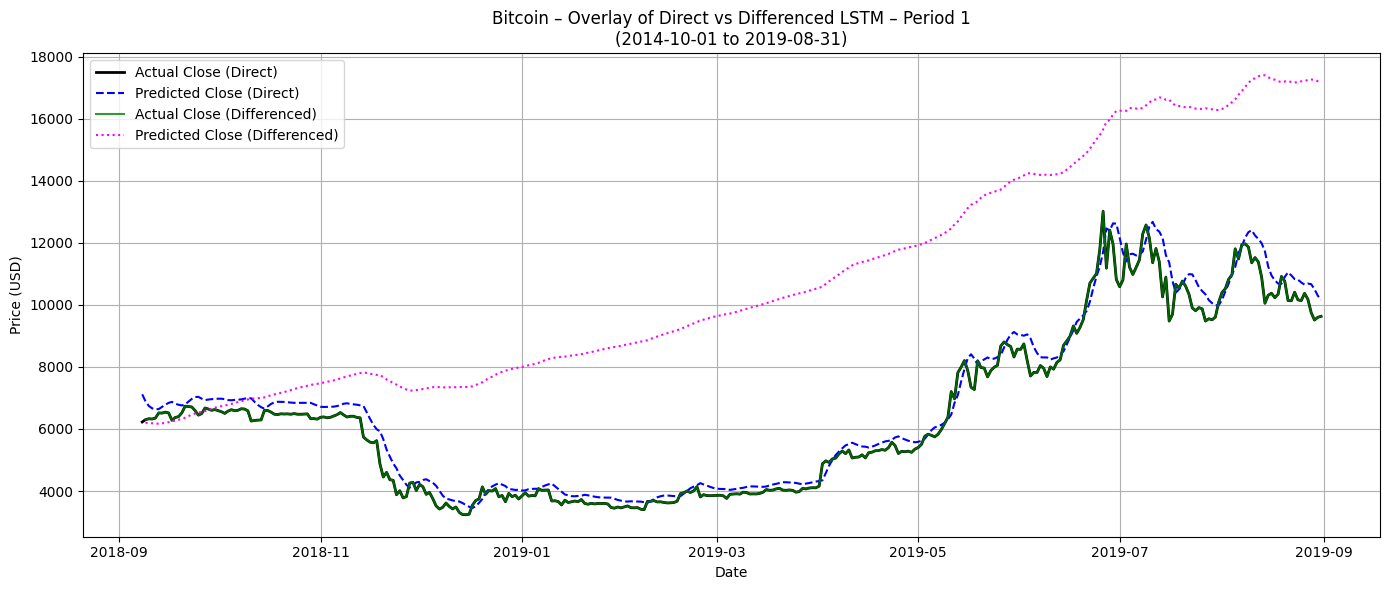


🚀 Running LSTM Comparison for Bitcoin – Period 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


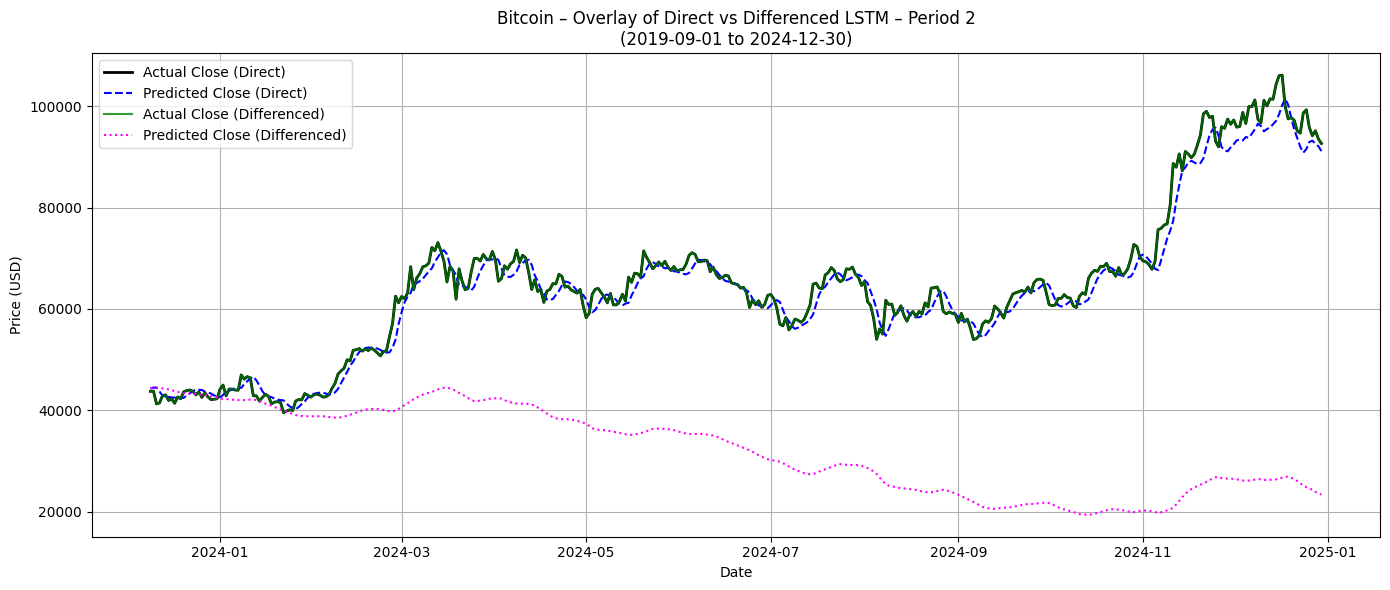


🚀 Running LSTM Comparison for Bitcoin – Period 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 📚 Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ Define Periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# ✅ Sequence Builder
def create_sequences(series, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

# ✅ Process Each Asset and Period
for asset_name, file_path in {
    "Bitcoin": "Bitcoin_data.csv",
    "Tesla": "Tesla_stock.csv"
}.items():
    print(f"\n📈 Processing: {asset_name}")

    df_raw = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=True)
    df_raw.set_index("Date", inplace=True)
    df_raw.sort_index(inplace=True)

    min_date, max_date = df_raw.index.min().date(), df_raw.index.max().date()
    print(f"🗓️ Available range: {min_date} to {max_date}")

    for label, (start, end) in periods.items():
        print(f"\n🚀 Running LSTM Comparison for {asset_name} – {label}")

        # ✅ Slice within available bounds
        df = df_raw.loc[
            max(pd.to_datetime(start), df_raw.index.min()):
            min(pd.to_datetime(end), df_raw.index.max())
        ].copy()

        if df.empty or len(df) < 20:
            print(f"❌ Skipping {label}: insufficient data for {asset_name}")
            continue

        # -------------------------------
        # 🧠 1. Direct LSTM
        # -------------------------------
        scaler_direct = MinMaxScaler()
        df["scaled_close"] = scaler_direct.fit_transform(df[["Close"]])

        X_d, y_d = create_sequences(df["scaled_close"].values.reshape(-1, 1))
        dates_d = df.index[10:]

        split = int(len(X_d) * 0.8)
        X_train_d, X_test_d = X_d[:split], X_d[split:]
        y_train_d, y_test_d = y_d[:split], y_d[split:]
        test_dates_d = dates_d[split:]

        model_d = Sequential([
            LSTM(64, input_shape=(X_d.shape[1], 1)),
            Dense(1)
        ])
        model_d.compile(optimizer='adam', loss='mse')
        model_d.fit(X_train_d, y_train_d, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        y_pred_d = model_d.predict(X_test_d)
        y_test_inv_direct = scaler_direct.inverse_transform(y_test_d.reshape(-1, 1))
        y_pred_inv_direct = scaler_direct.inverse_transform(y_pred_d)

        # -------------------------------
        # 🧠 2. Differenced LSTM
        # -------------------------------
        df["diff_close"] = df["Close"].diff()
        df.dropna(inplace=True)

        scaler_diff = MinMaxScaler()
        df["scaled_diff"] = scaler_diff.fit_transform(df[["diff_close"]])

        X_diff, y_diff = create_sequences(df["scaled_diff"].values.reshape(-1, 1))
        dates_diff = df.index[10:]

        split_diff = int(len(X_diff) * 0.8)
        X_train_diff, X_test_diff = X_diff[:split_diff], X_diff[split_diff:]
        y_train_diff, y_test_diff = y_diff[:split_diff], y_diff[split_diff:]
        test_dates_diff = dates_diff[split_diff:]

        model_diff = Sequential([
            LSTM(64, input_shape=(X_diff.shape[1], 1)),
            Dense(1)
        ])
        model_diff.compile(optimizer='adam', loss='mse')
        model_diff.fit(X_train_diff, y_train_diff, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

        y_pred_diff = model_diff.predict(X_test_diff)
        y_pred_inv_diff = scaler_diff.inverse_transform(y_pred_diff)
        y_test_inv_diff = scaler_diff.inverse_transform(y_test_diff.reshape(-1, 1))

        last_close = df["Close"].iloc[split_diff + 10 - 1]
        reconstructed_pred = np.r_[last_close, y_pred_inv_diff.flatten()].cumsum()[1:]
        reconstructed_actual = np.r_[last_close, y_test_inv_diff.flatten()].cumsum()[1:]

        # -------------------------------
        # 📈 Plot Overlay
        # -------------------------------
        plt.figure(figsize=(14, 6))

        plt.plot(test_dates_d, y_test_inv_direct, label="Actual Close (Direct)", color='black', linewidth=2)
        plt.plot(test_dates_d, y_pred_inv_direct, label="Predicted Close (Direct)", color='blue', linestyle='--', linewidth=1.5)
        plt.plot(test_dates_diff, reconstructed_actual, label="Actual Close (Differenced)", color='green', linewidth=1.5, alpha=0.8)
        plt.plot(test_dates_diff, reconstructed_pred, label="Predicted Close (Differenced)", color='magenta', linestyle=':', linewidth=1.5)

        plt.title(f"{asset_name} – Overlay of Direct vs Differenced LSTM – {label}\n({start} to {end})")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        fname = f"{asset_name.lower()}_overlay_direct_vs_diff_{label.replace(' ', '_')}.png"
        plt.savefig(fname, dpi=300)
        plt.show()


In [ ]:
from google.colab import files

# ✅ Combined PDF filename
combined_pdf = "BTC_TSLA_Overlay_Direct_vs_Differenced_LSTM.pdf"

# ✅ Trigger browser download (if file exists)
import os
if os.path.exists(combined_pdf):
    files.download(combined_pdf)
    print(f"📥 Download started for: {combined_pdf}")
else:
    print(f"❌ File not found: {combined_pdf}")


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np

# ✅ Load both assets
assets = {
    "Bitcoin": pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"]),
    "Tesla": pd.read_csv("Tesla_stock.csv", parse_dates=["Date"])
}

for name in assets:
    assets[name].set_index("Date", inplace=True)
    assets[name].sort_index(inplace=True)

# 📅 Global periods
periods = {
    "Period 1": ("2014-10-01", "2019-08-31"),
    "Period 2": ("2019-09-01", "2024-12-30"),
    "Period 3": ("2014-10-01", "2024-12-30")
}

# 🧠 Sequence generator
def create_sequences(series, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i + seq_len])
        y.append(series[i + seq_len])
    return np.array(X), np.array(y)

# 📦 Store results
results = {}

# 🔁 Loop over assets and periods
for asset_name, df in assets.items():
    print(f"\n📊 Processing: {asset_name}")
    results[asset_name] = {}

    for period, (start, end) in periods.items():
        print(f"🚀 Training Differenced LSTM – {asset_name} | {period} ({start} → {end})")

        df_period = df.loc[start:end].copy()

        # ✅ Check if there's enough data to difference
        if df_period.shape[0] < 11:
            print(f"⚠️ Skipping {asset_name} {period} – insufficient data.")
            continue

        # ✅ Differencing
        df_period["diff_close"] = df_period["Close"].diff()
        df_period.dropna(inplace=True)

        if df_period.empty:
            print(f"⚠️ Skipping {asset_name} {period} – no data after differencing.")
            continue

        # ✅ Scaling
        scaler = MinMaxScaler()
        df_period["scaled_diff"] = scaler.fit_transform(df_period[["diff_close"]])

        # ✅ Sequences
        seq_len = 10
        X, y = create_sequences(df_period["scaled_diff"].values.reshape(-1, 1), seq_len)
        dates = df_period.index[seq_len:]

        if len(X) == 0:
            print(f"⚠️ Skipping {asset_name} {period} – no sequences generated.")
            continue

        # ✅ Train/Test split
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = dates[split:]

        # ✅ Model
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(seq_len, 1)),
            Dropout(0.2),
            LSTM(64),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # ✅ Train
        model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            verbose=0
        )

        # ✅ Predict
        y_pred = model.predict(X_test)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # ✅ Store results
        results[asset_name][period] = {
            "y_test_inv": y_test_inv,
            "y_pred_inv": y_pred_inv,
            "dates": test_dates
        }

print("✅ All assets and periods processed.")


In [ ]:
# ✅ Save locally in Colab (current directory)
df_metrics.to_csv("differenced_lstm_summary_metrics.csv", index=False)

# ✅ Trigger download to browser
from google.colab import files
files.download("differenced_lstm_summary_metrics.csv")


In [ ]:
# Check sample data before computing metrics
for asset_name, result_dict in all_assets.items():
    for period in ["Period 1", "Period 2", "Period 3"]:
        if period in result_dict:
            print(f"\n🔍 {asset_name} - {period}")
            print("y_test_inv sample:", result_dict[period]["y_test_inv"][:5].flatten())
            print("y_pred_inv sample:", result_dict[period]["y_pred_inv"][:5].flatten())


In [ ]:
# After Bitcoin LSTM differenced training and prediction
results_diff_btc = results_diff.copy()  # or assign directly if not done yet

# After Tesla LSTM differenced training and prediction
results_diff_tsla = results_diff.copy()  # if you reused 'results_diff' again for Tesla


In [ ]:
print("Bitcoin periods:", list(results_diff_btc.keys()))
print("Tesla periods:", list(results_diff_tsla.keys()))


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# 📐 Define evaluation function
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    return round(rmse, 2), round(mse, 2), round(mae, 2), f"{mape:.2f}%", round(r2, 2)

# 🗂️ Combine results from both assets
all_assets = {
    "Bitcoin": results_diff_btc,
    "Tesla": results_diff_tsla
}

# 📦 Store metrics across all assets and periods
summary_metrics = []

# 🔁 Loop through assets and periods
for asset_name, result_dict in all_assets.items():
    for period in ["Period 1", "Period 2", "Period 3"]:
        if period not in result_dict:
            print(f"⚠️ Skipping {asset_name} – {period} not found.")
            continue

        y_true = result_dict[period]["y_test_inv"].flatten()
        y_pred = result_dict[period]["y_pred_inv"].flatten()

        rmse, mse, mae, mape, r2 = evaluate_metrics(y_true, y_pred)
        summary_metrics.append([asset_name, period, rmse, mse, mae, mape, r2])

# 📊 Create summary DataFrame
df_results = pd.DataFrame(summary_metrics, columns=["Asset", "Period", "RMSE", "MSE", "MAE", "MAPE", "R2"])
print(df_results)

# 💾 Save to CSV
csv_name = "differenced_lstm_evaluation_summary_combined.csv"
df_results.to_csv(csv_name, index=False)
print(f"✅ Evaluation summary saved as: {csv_name}")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# 📐 Evaluation function
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    return round(rmse, 2), round(mse, 2), round(mae, 2), f"{mape:.2f}%", round(r2, 2)

# 🗂️ Combine results from both assets
all_assets = {
    "Bitcoin": results_diff_btc,
    "Tesla": results_diff_tsla
}

# 📊 Compute metrics
summary_metrics = []

for asset, results in all_assets.items():
    for period in ["Period 1", "Period 2", "Period 3"]:
        if period not in results:
            print(f"⚠️ Skipping {asset} {period} — not found.")
            continue
        y_true = results[period]["y_test_inv"].flatten()
        y_pred = results[period]["y_pred_inv"].flatten()
        rmse, mse, mae, mape, r2 = evaluate_metrics(y_true, y_pred)
        summary_metrics.append([asset, period, rmse, mse, mae, mape, r2])

# 📄 DataFrame & Export
df_metrics = pd.DataFrame(summary_metrics, columns=["Asset", "Period", "RMSE", "MSE", "MAE", "MAPE", "R2"])
df_metrics.to_csv("differenced_lstm_summary_metrics.csv", index=False)
print("✅ Combined evaluation saved as: differenced_lstm_summary_metrics.csv")
print(df_metrics)


In [ ]:
from google.colab import files
files.download("differenced_lstm_summary_metrics.csv")


In [ ]:
# ✅ Trigger CSV file download in Google Colab
from google.colab import files
files.download("differenced_lstm_evaluation_summary.csv")
